# Prognoza liczby wypożyczonych rowerów

Załóżmy, że pracujemy w dziale **Data Science** firmy wypożyczającej rowery. Obecnie firma przygotowuje na swoich stanowiskach tyle rowerów, jaka była średnia z wypożyczonych rowerów w poprzednim tygodniu oraz w poprzednim roku.

Niewystarczająca liczba rowerów na stanowiskach to utracony zysk (-10 zł). 

Jeśli zbyt wiele rowerów jest na stanowisku to utrzymujemy rowery, które nie przynoszą zysku, a wcześniej musieliśmy je przywieźć (-1 zł).

Z niewiadomych nam przyczyn powinniśmy prognozować na następny tydzień 🤔

Skorzystamy z danych, które przygotował [Leif Arne Bakker](https://futurice.com/blog/business-forecasting-with-facebook-prophet). Dotyczą liczby rowerzystów na pewnym odcinku w Oslo (Norwegia). W danych jest również informacja o pogodzie oraz ilości opadów.

![bikeway](graphics/01_droga_rowerowa.png)

# 1. Import libraries

In [1]:
import os

# data manipulation
import numpy as np
import pandas as pd
import datetime as dt
import itertools
import time
from math import sqrt
from tqdm import tqdm


# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet.plot import plot

# statistical tests
from statsmodels.tsa.stattools import adfuller

# preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# models
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf

# optimization and hyperparameters
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# model evaluation
from sklearn.metrics import mean_squared_error
from fbprophet.diagnostics import cross_validation, performance_metrics

# settings
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 2. Load dataset

In [2]:
np.__version__

'1.19.2'

In [3]:
dataframe = pd.read_csv('bikerides_day.csv')
dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe

,Date,Volume,Rain,Temp
0,2016-11-17,933.0,9.0,2.1
1,2016-11-18,1197.0,6.7,3.9
2,2016-11-19,243.0,5.4,2.0
3,2016-11-20,234.0,3.9,2.8
4,2016-11-21,2148.0,7.3,2.8
...,...,...,...,...
1268,2020-05-16,2484.0,0.0,6.6
1269,2020-05-17,1509.0,0.0,9.1
1270,2020-05-18,5775.0,0.0,9.3
1271,2020-05-19,6741.0,0.0,9.7


# 3. Exploratory Data Analysis

Czy są wartości brakujące?

In [4]:
dataframe.isnull().mean()*100

Date      0.0
Volume    0.0
Rain      0.0
Temp      0.0
dtype: float64

Czy daty się duplikują?

In [5]:
dataframe.loc[dataframe.duplicated(subset='Date', keep=False), :]

,Date,Volume,Rain,Temp


Czy daty są posortowane?

In [6]:
(dataframe['Date'] == dataframe['Date'].sort_values()).all()

True

Czy są wszystkie daty?

In [7]:
pd.date_range(start=dataframe['Date'].min(), end=dataframe['Date'].max()).difference(dataframe['Date'])

DatetimeIndex(['2017-10-16', '2019-01-14', '2019-06-07', '2019-06-08',
               '2019-06-09', '2019-06-10', '2019-08-14', '2019-08-15'],
              dtype='datetime64[ns]', freq=None)

In [8]:
dataframe.loc[dataframe['Date']=='2017-10-16',:]

,Date,Volume,Rain,Temp


In [9]:
dataframe.loc[dataframe['Date']=='2019-08-14',:]

,Date,Volume,Rain,Temp


Jaki jest rozkład naszych danych?

In [10]:
dataframe.describe()

,Volume,Rain,Temp
count,1273.000000,1273.000000,1273.000000
mean,2609.344855,1.945640,6.783975
std,1968.623825,4.505151,7.726084
min,63.000000,0.000000,-11.400000
25%,1185.000000,0.000000,0.700000
50%,2073.000000,0.000000,5.500000
75%,3801.000000,1.400000,13.400000
max,8679.000000,39.500000,25.900000


Jak wyglądają nasze dane w czasie?

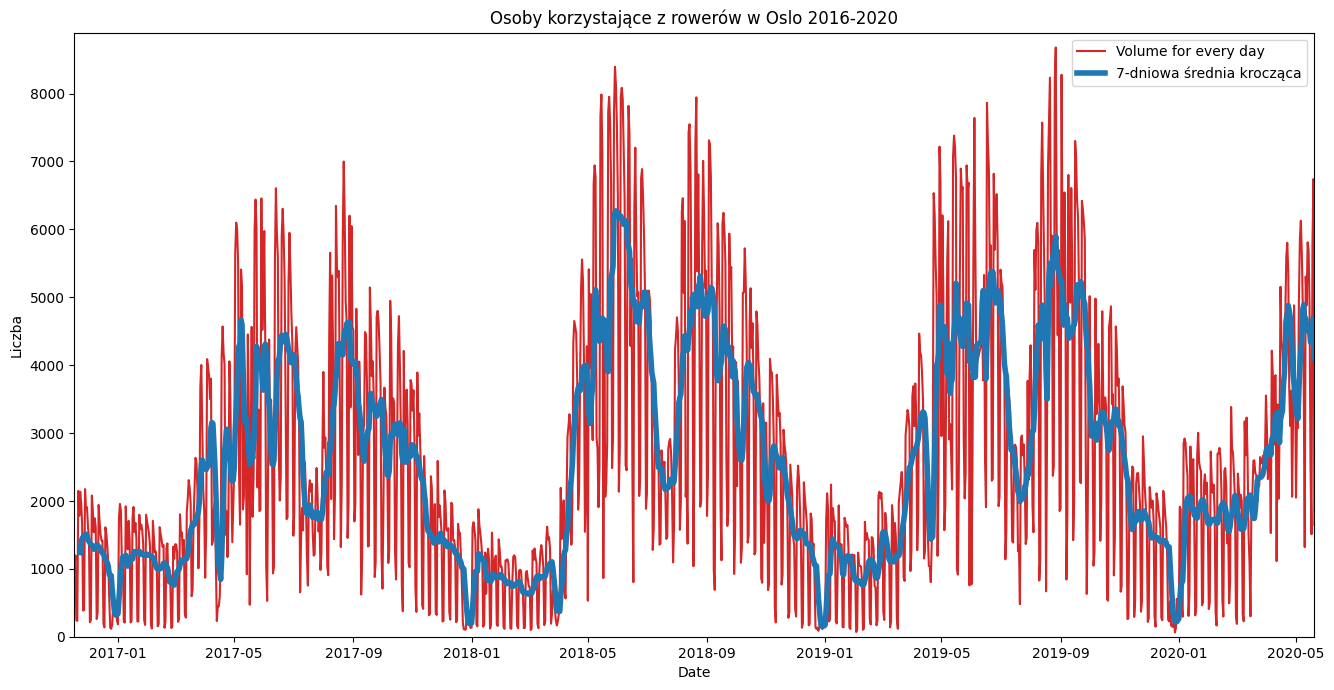

In [11]:
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(dataframe['Date'], dataframe['Volume'],
         color='tab:red', label='Volume for every day')
plt.plot(dataframe['Date'], dataframe['Volume'].rolling(7).mean(),
         color='tab:blue', linewidth=4, label='7-dniowa średnia krocząca')
plt.title('Osoby korzystające z rowerów w Oslo 2016-2020')
plt.xlabel('Date')
plt.ylabel('Liczba')
plt.xlim([dataframe['Date'].min(), dataframe['Date'].max()])
plt.ylim([0, dataframe['Volume'].max()*1.025])
plt.legend(loc='upper right')
plt.show()

In [12]:
full_years = dataframe.loc[(dataframe['Date'] >= '2017-01-01') & (dataframe['Date'] < '2020-01-01')].copy()
full_years['year'] = [d.year for d in full_years['Date']]
full_years['month'] = [d.strftime('%b') for d in full_years['Date']]
full_years['weekday'] = [d.strftime('%A') for d in full_years['Date']]

full_years

,Date,Volume,Rain,Temp,year,month,weekday
45,2017-01-01,183.0,0.0,1.1,2017,Jan,Sunday
46,2017-01-02,1752.0,0.0,-2.8,2017,Jan,Monday
47,2017-01-03,1956.0,0.0,-2.5,2017,Jan,Tuesday
48,2017-01-04,1854.0,0.0,-3.1,2017,Jan,Wednesday
49,2017-01-05,1113.0,0.0,-10.1,2017,Jan,Thursday
...,...,...,...,...,...,...,...
1127,2019-12-27,342.0,0.0,-4.9,2019,Dec,Friday
1128,2019-12-28,63.0,0.0,-1.2,2019,Dec,Saturday
1129,2019-12-29,126.0,5.9,4.4,2019,Dec,Sunday
1130,2019-12-30,558.0,0.0,5.5,2019,Dec,Monday


In [13]:
full_years_monthly = full_years.groupby(['year', 'month'])[['Volume']].mean()
full_years_monthly.reset_index(inplace=True)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
full_years_monthly['month'] = pd.Categorical(full_years_monthly['month'], categories=months, ordered=True)

full_years_monthly.sort_values(by=['year', 'month'], inplace=True)
full_years_monthly

,year,month,Volume
4,2017,Jan,1202.225806
3,2017,Feb,980.250000
7,2017,Mar,1703.419355
0,2017,Apr,2283.500000
8,2017,May,3719.903226
6,2017,Jun,3890.900000
5,2017,Jul,2118.096774
1,2017,Aug,3900.000000
11,2017,Sep,3226.500000
10,2017,Oct,2769.100000


2017
2018
2019


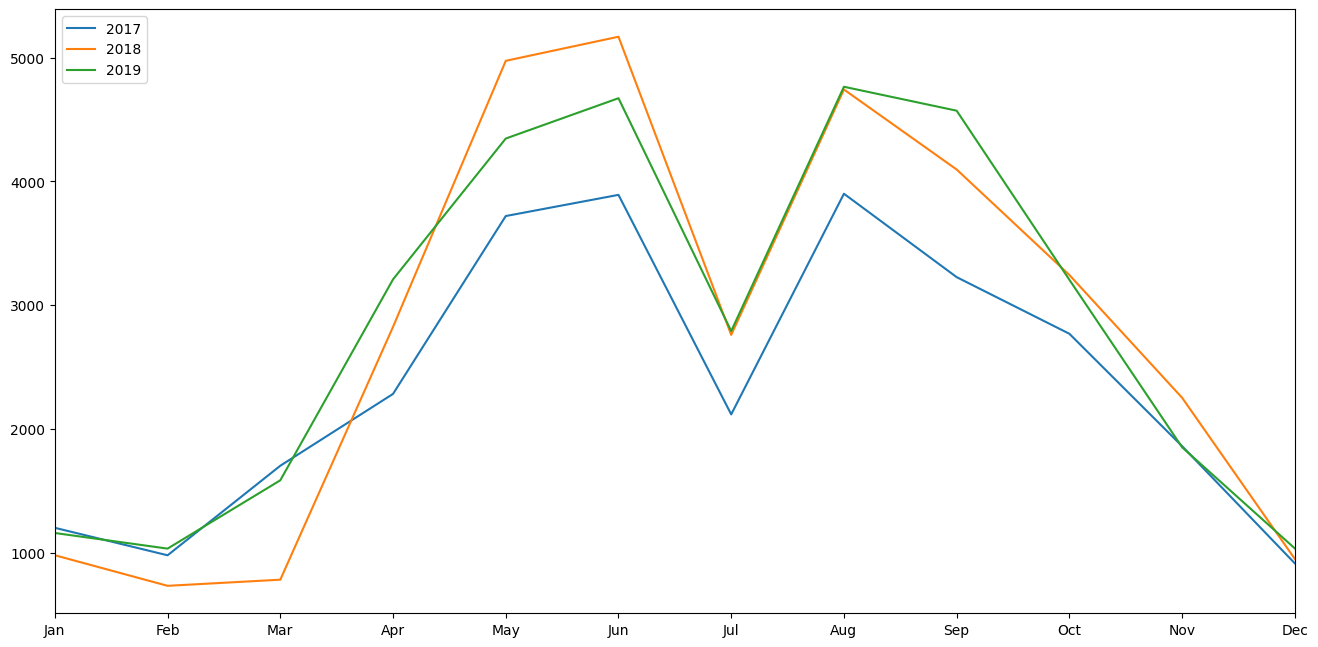

In [14]:
plt.figure(figsize=(16, 8), dpi=100)
for year in full_years['year'].unique():
    plt.plot(full_years_monthly.loc[full_years_monthly['year']==year, 'month'],
             full_years_monthly.loc[full_years_monthly['year']==year, 'Volume'], label=year)
    print(year)
plt.legend(loc='upper left')
plt.xlim(['Jan', 'Dec'])
plt.show()

#### Box plots

- Rok (trend)
- Miesiąc (sezonowość)
- Dzień tygodnia (sezonowość)

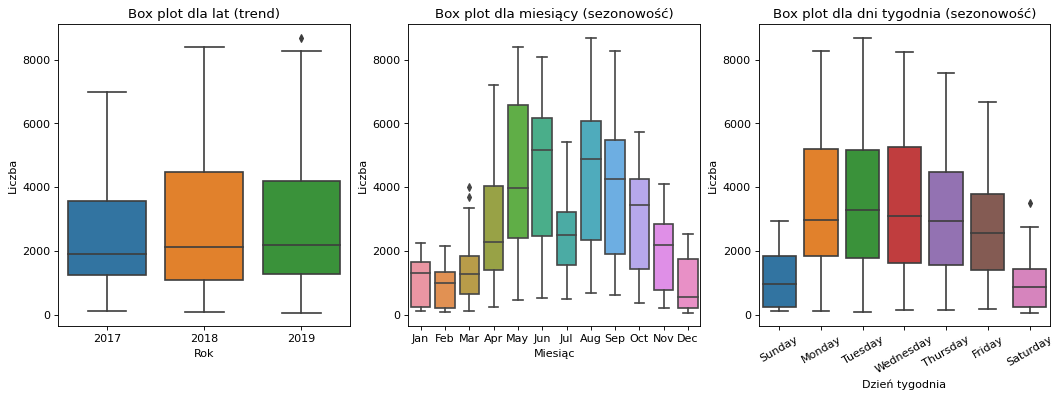

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=80)

sns.boxplot(x='year', y='Volume', data=full_years, ax=axes[0]).set(
    xlabel='Rok', 
    ylabel='Liczba'
)
axes[0].set_title('Box plot dla lat (trend)')

sns.boxplot(x='month', y='Volume', data=full_years, ax=axes[1]).set(
    xlabel='Miesiąc', 
    ylabel='Liczba'
)
axes[1].set_title('Box plot dla miesiący (sezonowość)')

sns.boxplot(x='weekday', y='Volume', data=full_years, ax=axes[2]).set(
    xlabel='Dzień tygodnia', 
    ylabel='Liczba'
)
axes[2].set_title('Box plot dla dni tygodnia (sezonowość)')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=30)

plt.show()

Wykres zależności obserwacji szeregu od opóźnień

Wykres zależności obserwacji szeregu od opóźnień zwykle służy do sprawdzania autokorelacji. Jeśli na wykresie rozproszenia zauważalny jest jakikolwiek wzorzec, wówczas możemy sądzić, że szereg jest autoskorelowany. Jeśli punkty układają się w sposób losowy, wówczas będzie przypadkowym *białym szumem*.

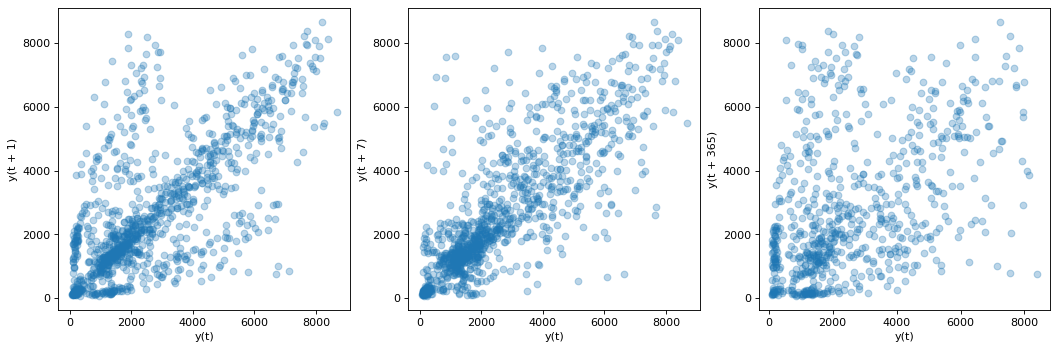

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=80)
pd.plotting.lag_plot(full_years['Volume'], lag=1, ax=axes[0], alpha=0.3)
pd.plotting.lag_plot(full_years['Volume'], lag=7, ax=axes[1], alpha=0.3)
pd.plotting.lag_plot(full_years['Volume'], lag=365, ax=axes[2], alpha=0.3)
plt.show()

Wpływ pogody na liczbę rowerzystów

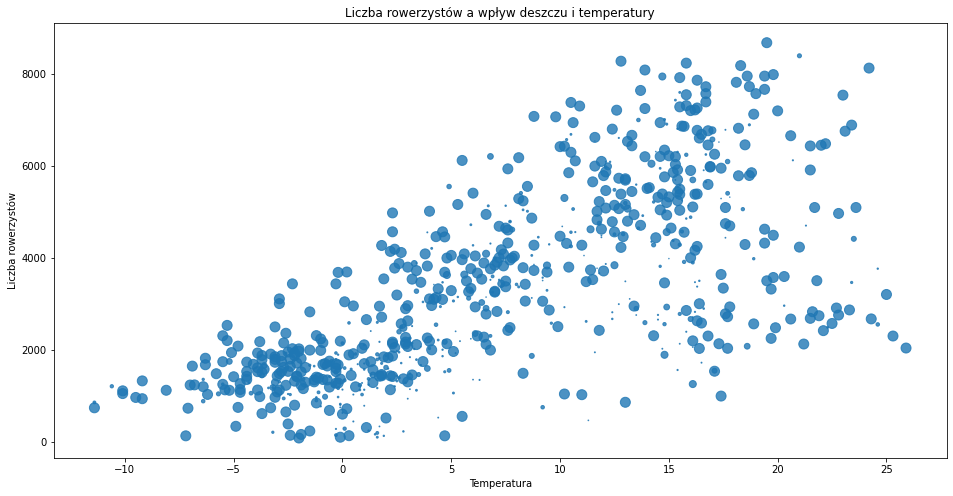

In [17]:
full_years.loc[full_years['Rain']==0, 'Rain'] = 0.1

plt.figure(figsize=(16, 8))
plt.scatter(full_years.loc[~full_years['weekday'].isin(['Saturday', 'Sunday']), 'Temp'], 
            full_years.loc[~full_years['weekday'].isin(['Saturday', 'Sunday']), 'Volume'], 
            s=10/full_years.loc[~full_years['weekday'].isin(['Saturday', 'Sunday']), 'Rain'],
            alpha=0.8)
plt.title('Liczba rowerzystów a wpływ deszczu i temperatury')
plt.xlabel('Temperatura')
plt.ylabel('Liczba rowerzystów')
plt.show()

# Data preprocessing

In [18]:
dataframe

,Date,Volume,Rain,Temp
0,2016-11-17,933.0,9.0,2.1
1,2016-11-18,1197.0,6.7,3.9
2,2016-11-19,243.0,5.4,2.0
3,2016-11-20,234.0,3.9,2.8
4,2016-11-21,2148.0,7.3,2.8
...,...,...,...,...
1268,2020-05-16,2484.0,0.0,6.6
1269,2020-05-17,1509.0,0.0,9.1
1270,2020-05-18,5775.0,0.0,9.3
1271,2020-05-19,6741.0,0.0,9.7


In [19]:
dataframe_prepared = dataframe.copy()
dataframe_prepared.index = dataframe_prepared['Date']
dataframe_prepared.drop(['Date'], axis=1, inplace=True)
idx = pd.date_range(dataframe_prepared.index.min(), dataframe_prepared.index.max())
dataframe_prepared = dataframe_prepared.reindex(idx)
display(dataframe_prepared)

print('Nan Values:')
display(dataframe_prepared.loc[dataframe_prepared['Volume'].isnull(), :])

# Liczba rowerzystów, jak i pogoda taka jak tydzień wcześniej
dataframe_prepared.loc[dataframe_prepared['Volume'].isnull(), 'Volume'] = dataframe_prepared['Volume'].shift(7)
dataframe_prepared.loc[dataframe_prepared['Rain'].isnull(), 'Rain'] = dataframe_prepared['Rain'].shift(7)
dataframe_prepared.loc[dataframe_prepared['Temp'].isnull(), 'Temp'] = dataframe_prepared['Temp'].shift(7)

dataframe_prepared

,Volume,Rain,Temp
2016-11-17,933.0,9.0,2.1
2016-11-18,1197.0,6.7,3.9
2016-11-19,243.0,5.4,2.0
2016-11-20,234.0,3.9,2.8
2016-11-21,2148.0,7.3,2.8
...,...,...,...
2020-05-16,2484.0,0.0,6.6
2020-05-17,1509.0,0.0,9.1
2020-05-18,5775.0,0.0,9.3
2020-05-19,6741.0,0.0,9.7


Nan Values:


,Volume,Rain,Temp
2017-10-16,NaN,NaN,NaN
2019-01-14,NaN,NaN,NaN
2019-06-07,NaN,NaN,NaN
2019-06-08,NaN,NaN,NaN
2019-06-09,NaN,NaN,NaN
2019-06-10,NaN,NaN,NaN
2019-08-14,NaN,NaN,NaN
2019-08-15,NaN,NaN,NaN


,Volume,Rain,Temp
2016-11-17,933.0,9.0,2.1
2016-11-18,1197.0,6.7,3.9
2016-11-19,243.0,5.4,2.0
2016-11-20,234.0,3.9,2.8
2016-11-21,2148.0,7.3,2.8
...,...,...,...
2020-05-16,2484.0,0.0,6.6
2020-05-17,1509.0,0.0,9.1
2020-05-18,5775.0,0.0,9.3
2020-05-19,6741.0,0.0,9.7


In [20]:
dataframe_prepared.loc[dataframe_prepared['Temp'].isnull(), :]

,Volume,Rain,Temp


# Train Test Split

![train_test_split](graphics/02_Train_Test_split.jpg)

In [21]:
first_test_date = dt.datetime.strptime('2020-01-01', '%Y-%m-%d')

print('Train dataset:')
train_dataset = dataframe_prepared.loc[dataframe_prepared.index<first_test_date, :].copy()
display(train_dataset)

print('\nTest dataset:')
test_dataset = dataframe_prepared.loc[dataframe_prepared.index>=first_test_date, :].copy()
display(test_dataset)

Train dataset:


,Volume,Rain,Temp
2016-11-17,933.0,9.0,2.1
2016-11-18,1197.0,6.7,3.9
2016-11-19,243.0,5.4,2.0
2016-11-20,234.0,3.9,2.8
2016-11-21,2148.0,7.3,2.8
...,...,...,...
2019-12-27,342.0,0.0,-4.9
2019-12-28,63.0,0.0,-1.2
2019-12-29,126.0,5.9,4.4
2019-12-30,558.0,0.0,5.5



Test dataset:


,Volume,Rain,Temp
2020-01-01,300.0,0.0,1.9
2020-01-02,1914.0,0.0,4.1
2020-01-03,1878.0,0.0,4.5
2020-01-04,456.0,0.1,0.7
2020-01-05,294.0,0.0,-0.1
...,...,...,...
2020-05-16,2484.0,0.0,6.6
2020-05-17,1509.0,0.0,9.1
2020-05-18,5775.0,0.0,9.3
2020-05-19,6741.0,0.0,9.7


# Modeling

## 1. Baseline

Model podstawowy, to taki do którego porownujemy nasze modele - może być to prosta statystyka, jak średnia, bądź coś bardziej zaawansowanego, ale nadal podstawowego - u nas to będzie średnia z wartości, która była rok temu oraz tydzień wcześniej.

In [22]:
y_test = dataframe_prepared.loc[dataframe_prepared.index>='2020-01-07', 'Volume'].copy()
y_test

2020-01-07    2919.0
2020-01-08    2859.0
2020-01-09    2562.0
2020-01-10    2361.0
2020-01-11     306.0
               ...  
2020-05-16    2484.0
2020-05-17    1509.0
2020-05-18    5775.0
2020-05-19    6741.0
2020-05-20    1647.0
Freq: D, Name: Volume, Length: 135, dtype: float64

In [23]:
prediction_baseline = dataframe_prepared['Volume'].copy()
prediction_baseline = np.round((prediction_baseline.shift(364) + prediction_baseline.shift(7)) / 2)
prediction_baseline.dropna(inplace=True)
prediction_baseline = prediction_baseline[prediction_baseline.index>='2020-01-07']
prediction_baseline

2020-01-07     886.0
2020-01-08    1096.0
2020-01-09    1815.0
2020-01-10    1788.0
2020-01-11     342.0
               ...  
2020-05-16    2298.0
2020-05-17    1958.0
2020-05-18    5312.0
2020-05-19    5888.0
2020-05-20    6192.0
Freq: D, Name: Volume, Length: 135, dtype: float64

In [24]:
def plot_prediction_vs_true(yhat, ytest):
    plt.figure(figsize=(16, 8), dpi=100)
    plt.plot(ytest, color='blue', label='True')
    plt.plot(yhat, color='black', label='Prediction')
    plt.xlim([ytest.index.min(), ytest.index.max()])
    plt.legend(loc='upper left')
    plt.show()

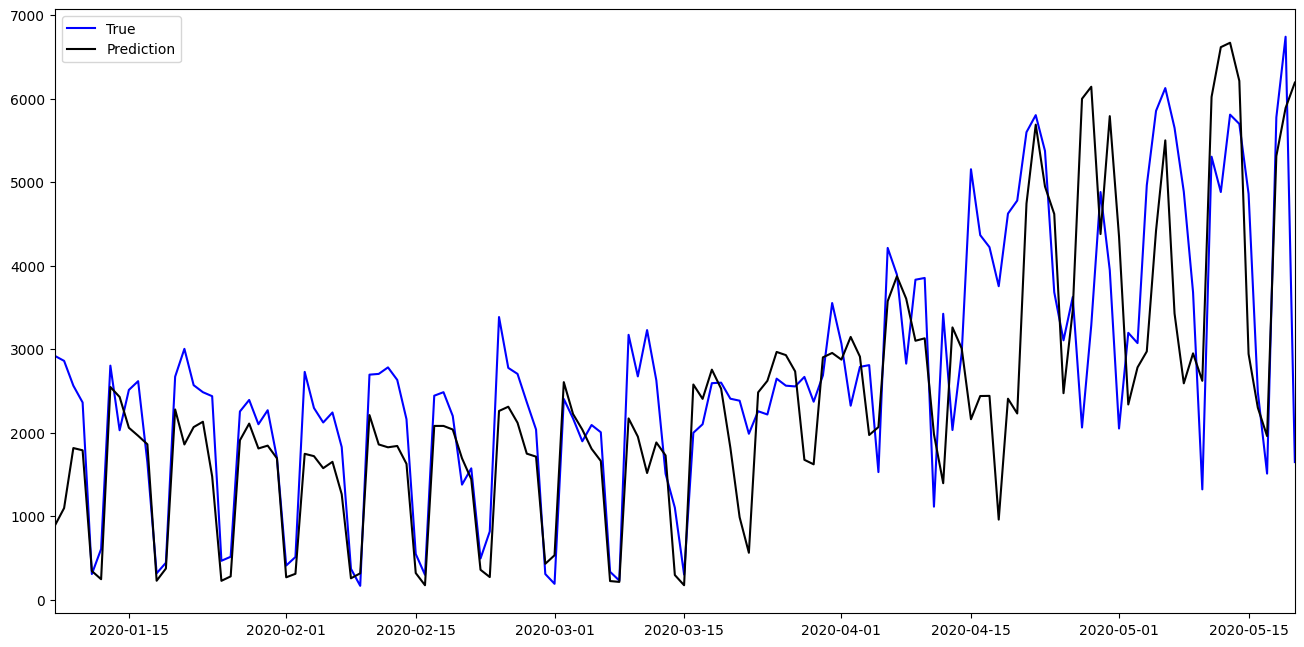

In [25]:
plot_prediction_vs_true(yhat=prediction_baseline, ytest=y_test)

In [26]:
def model_evaluation(yhat, ytest):
    def fit_scatter_plot(yhat, ytest):
        xmin = ytest.min()
        xmax = ytest.max()
        plt.scatter(x = yhat, y = ytest, alpha=0.25)
        x_line = np.linspace(xmin, xmax, 10)
        y_line = x_line
        plt.plot(x_line, y_line, 'r--')
        plt.xlabel('Predykcja')
        plt.ylabel('Wartość Prawdziwa')
        plt.title(f'Wykres predykcji względem wartości prawdziwych - Test set')
    
    def plot_of_residuals(yhat, ytest):
        errors = yhat - ytest
        plt.scatter(x = ytest, y = errors, alpha=0.25)
        plt.axhline(0, color="r", linestyle="--")
        plt.xlabel('Wartość Prawdziwa')
        plt.ylabel('Reszta')
        plt.title(f'Wykres reszt - Test set')
        
    def hist_of_residuals(yhat, ytest):
        errors = yhat - ytest
        plt.hist(errors, bins = 100)
        plt.axvline(errors.mean(), color='k', linestyle='dashed', linewidth=1)
        plt.title(f'Histogram reszt - Test set')
    
    def Cost(y_pred, y_true):
        def apply_cost(x):
            if x < 0:
                x = np.abs(x)*10
            return x
        y_pred = np.round(y_pred)
        cost = y_pred - y_true
        cost = cost.apply(apply_cost)
        return np.sum(cost)
    
    fig = plt.figure(figsize = (18, 6))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    ax = fig.add_subplot(1, 3, 1)
    fit_scatter_plot(yhat, ytest)
    
    ax = fig.add_subplot(1, 3, 2)
    plot_of_residuals(yhat, ytest)
    
    ax = fig.add_subplot(1, 3, 3)
    hist_of_residuals(yhat, ytest)
    
    plt.show()
    
    print(f'RMSE Test: {sqrt(mean_squared_error(ytest, yhat))}')
    print(f'Pomniejszony zysk: {Cost(yhat, ytest)}')

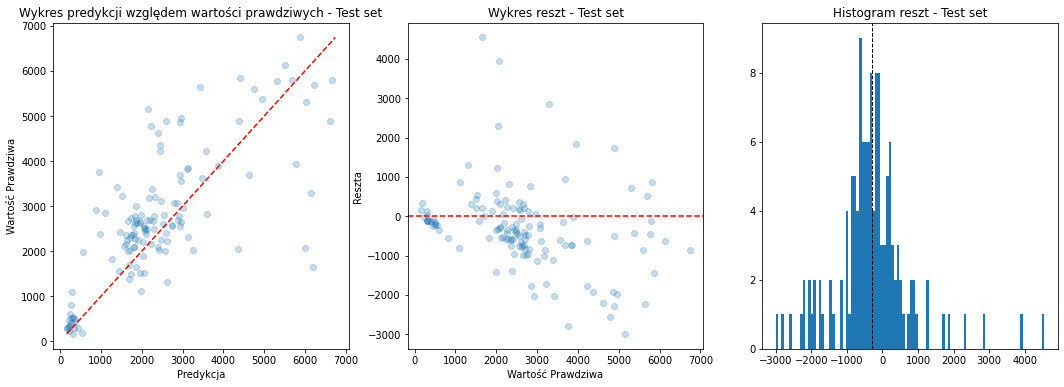

RMSE Test: 1101.9044524014876
Pomniejszony zysk: 755282.0


In [27]:
model_evaluation(yhat=prediction_baseline, ytest=y_test)

## 2. SARIMAX
Metoda statystyczna polegająca na modelowaniu szeregów czasowych, które są stacjonarne (w uogólnieniu stacjonarność oznacza stały w czasie rozkład - średnia czy wariancja). O tym za chwilę...

Dekompozycja - szereg czasowy składać się może z następujących składników:
- trend - następuje stały wzrost lub spadek wartości
- sezonowość - wartości zmieniają się z określoną częstotliwością (rok, tydzień)
- cyklicznośc - wahania następują z nieznaną częstotliwością (cykle koniunkturalne)
- reszty - niewyjaśnione wartości (szum).

In [28]:
y_train_arima = train_dataset['Volume'].copy()
y_train_arima

2016-11-17     933.0
2016-11-18    1197.0
2016-11-19     243.0
2016-11-20     234.0
2016-11-21    2148.0
               ...  
2019-12-27     342.0
2019-12-28      63.0
2019-12-29     126.0
2019-12-30     558.0
2019-12-31     315.0
Freq: D, Name: Volume, Length: 1140, dtype: float64

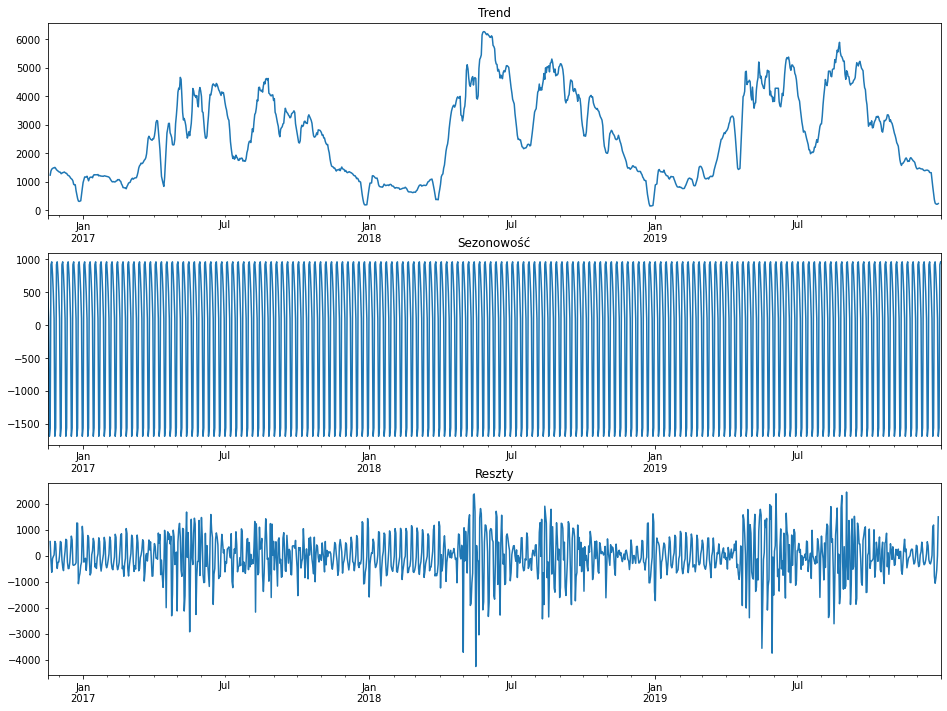

In [29]:
res = seasonal_decompose(y_train_arima, period=7)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(16,12))
res.trend.plot(ax=ax1)
ax1.set_title('Trend')
res.seasonal.plot(ax=ax2)
ax2.set_title('Sezonowość')
res.resid.plot(ax=ax3)
ax3.set_title('Reszty')
plt.show()

Szereg czasowy można uznać, jeśli **średnia** krocząca oraz **odchylenie standardowe** kroczące są niezmienne w czasie - można to zweryfikować patrząc na wykres i te metryki.

Innym sposobem jest sprawdzenie **Rozszerzonego testu Dickeya-Fullera** - Szereg czasowy jest uważany za stacjonarny, jeśli wartość p jest niska (zgodnie z hipotezą zerową), a wartości krytyczne przy przedziałach ufności 1%, 5%, 10% są jak najbardziej zbliżone do statystyk ADF. Aby odrzucić hipotezę zerową i zamiast tego zaakceptować hipotezę alternatywną, że stacjonarność istnieje to p-value musi być mniejsze niż poziom istoności oraz statystyka testowa mniejsza niż wszystkie wartości krytyczne.

Co jeśli nasz szereg nie jest stacjonarcy - zróbmy go stacjonarnym:
- **Transformacja logarytmiczna** - warto stosować jeśli wariancja zmienia się wraz z poziomem szeregu, dzieje sie tak na przykład podczas wahań sezonowych.
- **Różnicowanie** - oryginalne wartości zamieniamy różnicami. Dobierając odpowiednio opóźnienie możemy usunąć sezonowość bądź trend.

In [30]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    fig = plt.figure(figsize=(16,5))
    plt.plot(timeseries)
    plt.plot(timeseries.rolling(60).mean(), label='Rolling mean')
    plt.plot(timeseries.rolling(60).std(), label='Rolling std')
    plt.xlim([y_train_arima.index.min(), y_train_arima.index.max()])
    plt.legend(loc='upper left')
    plt.show()

Surowe dane:

Results of Dickey-Fuller Test:
Test Statistic                   -2.869918
p-value                           0.048960
#Lags Used                       22.000000
Number of Observations Used    1117.000000
Critical Value (1%)              -3.436218
Critical Value (5%)              -2.864131
Critical Value (10%)             -2.568150
dtype: float64


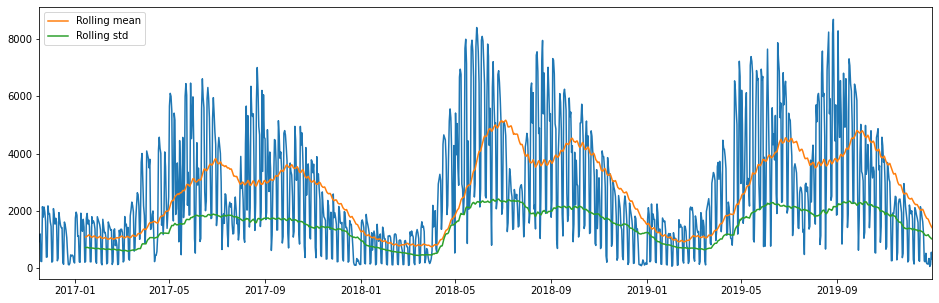

Logarytmowane dane:

Results of Dickey-Fuller Test:
Test Statistic                   -2.260585
p-value                           0.184995
#Lags Used                       22.000000
Number of Observations Used    1117.000000
Critical Value (1%)              -3.436218
Critical Value (5%)              -2.864131
Critical Value (10%)             -2.568150
dtype: float64


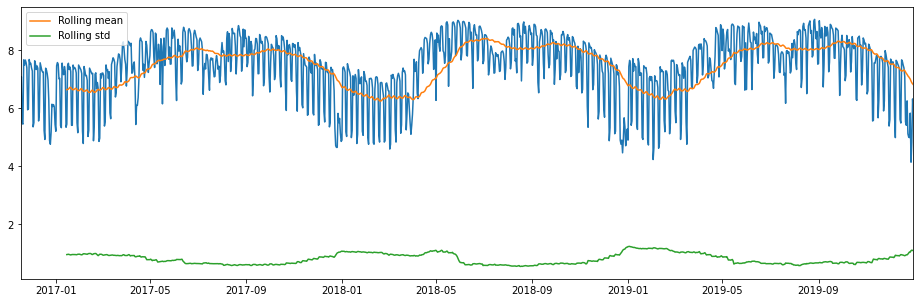

Różnicowanie tygodniowe:

Results of Dickey-Fuller Test:
Test Statistic                -7.695354e+00
p-value                        1.384005e-11
#Lags Used                     2.100000e+01
Number of Observations Used    1.111000e+03
Critical Value (1%)           -3.436250e+00
Critical Value (5%)           -2.864145e+00
Critical Value (10%)          -2.568157e+00
dtype: float64


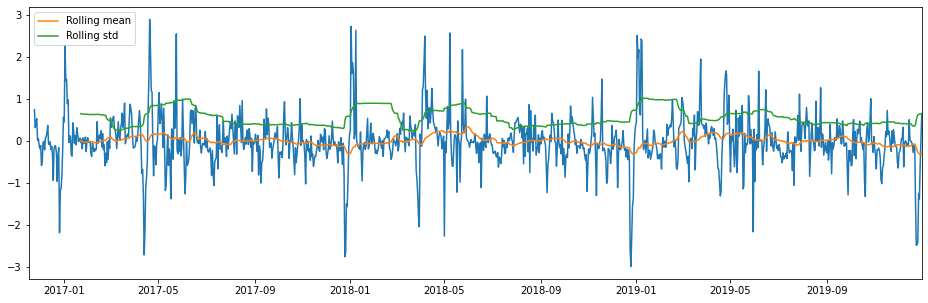

Różnicowanie roczne:

Results of Dickey-Fuller Test:
Test Statistic                -1.008581e+01
p-value                        1.156289e-17
#Lags Used                     2.000000e+01
Number of Observations Used    7.470000e+02
Critical Value (1%)           -3.439134e+00
Critical Value (5%)           -2.865417e+00
Critical Value (10%)          -2.568834e+00
dtype: float64


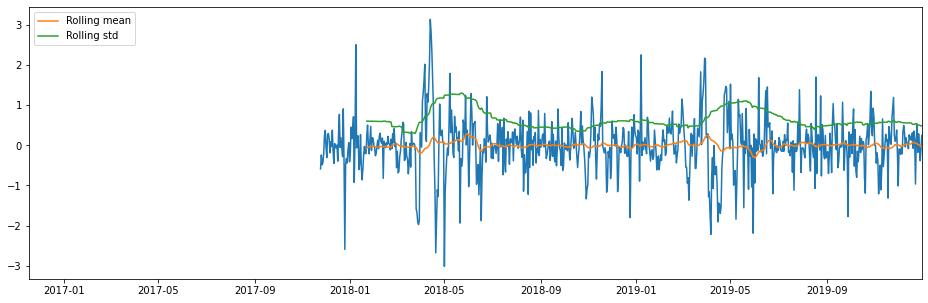

In [31]:
# Surowe dane
print('Surowe dane:\n')
y_train_transformed = y_train_arima.copy()
adf_test(y_train_transformed)

# Logarytmowane dane
print('Logarytmowane dane:\n')
y_train_transformed = np.log(y_train_transformed)
adf_test(y_train_transformed)

# Różnicowanie tygodniowe
print('Różnicowanie tygodniowe:\n')
y_train_transformed = y_train_transformed.diff(7)
y_train_transformed.dropna(inplace=True)
adf_test(y_train_transformed)

# Różnicowanie roczne
print('Różnicowanie roczne:\n')
y_train_transformed = y_train_transformed.diff(365)
y_train_transformed.dropna(inplace=True)
adf_test(y_train_transformed)


Model **SARIMAX** jest oparty o parametry:
- **S** - sezonowość - dane różnią się w zależności od pory roku. (*s*)
- **AR** - autoregresja - dane są podobne do poprzednich danych w dowolnym przedziale czasowym lub wcześniejszym okresie. Mówiąc prościej, reprezentuje powtarzające się wzorce w danych. Autoregresja oznacza, że dane są poddawane regresji z pewnym opóźnieniem w stosunku do poprzednich danych i znajduje miejsce, w którym regresja jest najsilniejsza, reprezentując wzorzec w danych. (*p*)
- **I** - zintegrowany - dane zostały zastąpione wartościami zróżnicowanymi. (*d*)
- **MA** - średnia krocząca - służy do redukcji szumów w modelu lub ich wygładzenia. Im dłuższy okres średniej ruchomej, tym bardziej wygładzony byłby szum. (*q*)
- **X** - zmienna objaśniająca, która wyjaśnia poniekąd szum.

- jeśli autokorelacja próbkowa $\text{ACF}(h)$ znajduje się pomiędzy przedziałami ufności, to spodziewamy się, że dane są realizacją procesu $\text{MA}(q)$
- jeśli cząstkowa autokorelacja próbkowa $\text{PACF}(h)$ znajduje się pomiędzy przedziałami ufności, to spodziewamy się, że dane są realizacją procesu $\text{AR}(p)$

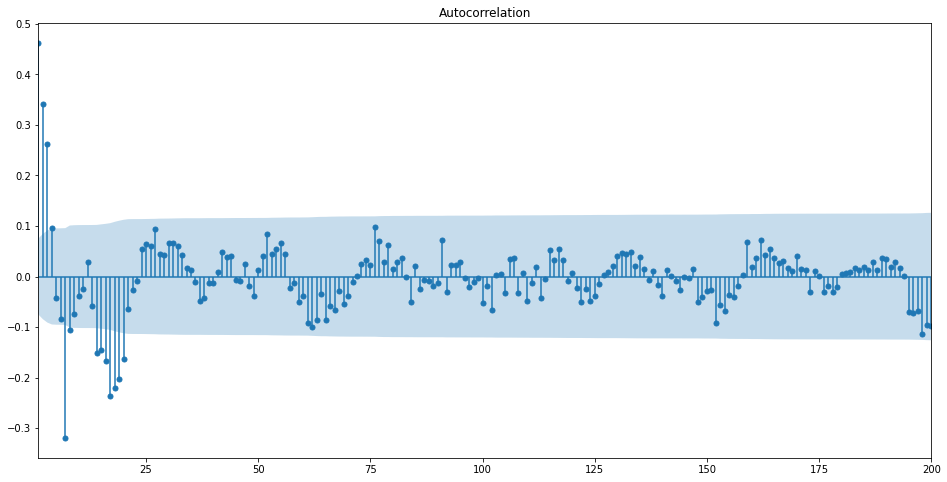

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_acf(y_train_transformed, lags=200, zero=False, ax=ax)
ax.set_xlim([1, 200])
plt.show()

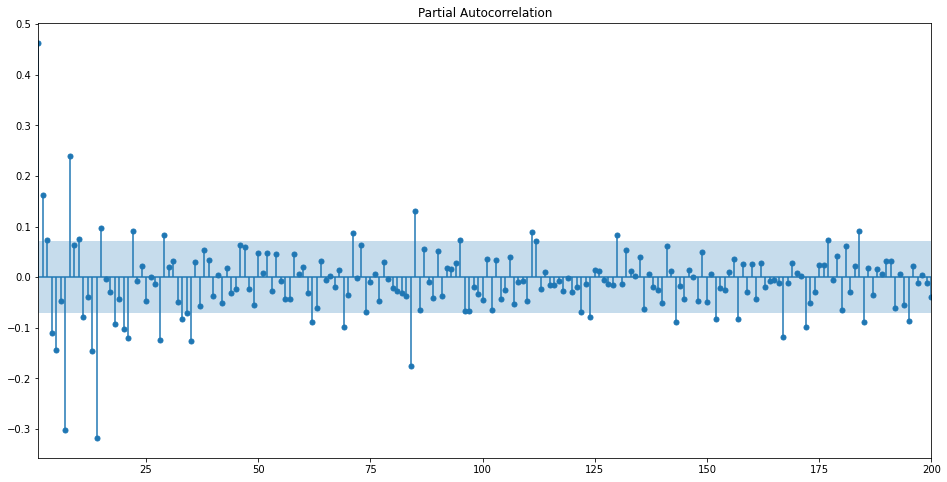

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_pacf(y_train_transformed, lags=200, zero=False, ax=ax)
ax.set_xlim([1, 200])
plt.show()

Zmienne objaśniające:

In [34]:
X_train_arima = train_dataset[['Rain', 'Temp']].copy()
X_train_arima = X_train_arima.loc[X_train_arima.index.isin(y_train_transformed.index), :]
X_train_arima

,Rain,Temp
2017-11-24,3.1,2.6
2017-11-25,0.0,0.9
2017-11-26,0.6,2.0
2017-11-27,1.5,0.3
2017-11-28,1.1,-0.5
...,...,...
2019-12-27,0.0,-4.9
2019-12-28,0.0,-1.2
2019-12-29,5.9,4.4
2019-12-30,0.0,5.5


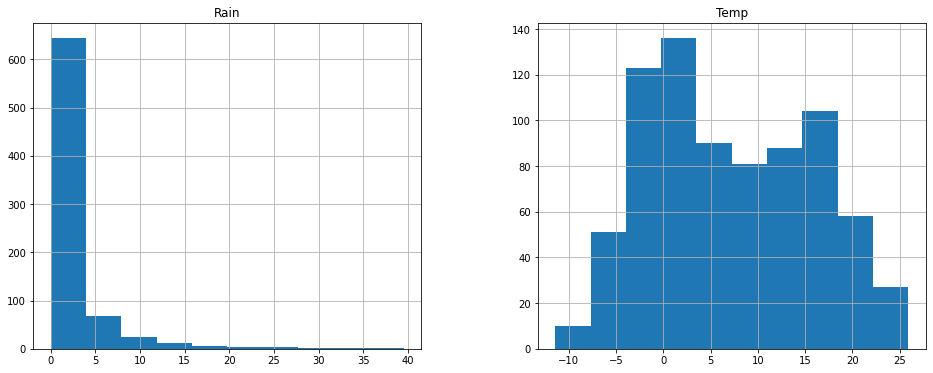

In [35]:
X_train_arima.hist(figsize=(16, 6), bins=10)
plt.show()

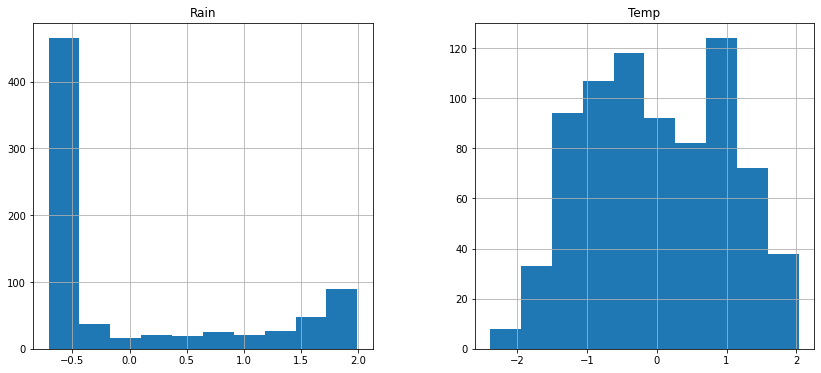

In [36]:
X_train_transformed = X_train_arima.copy()

scaler_first = StandardScaler()
X_train_transformed = scaler_first.fit_transform(X_train_transformed)

power_transformer = PowerTransformer()
X_train_transformed = power_transformer.fit_transform(X_train_transformed)

scaler_second = StandardScaler()
X_train_transformed = scaler_second.fit_transform(X_train_transformed)

X_train_transformed = pd.DataFrame(X_train_transformed, columns=['Rain', 'Temp'])
X_train_transformed.index = y_train_transformed.index
X_train_transformed.hist(figsize=(14, 6), bins=10)
plt.show()

In [37]:
# Trenowanie modelu
auto_arima_model = pm.auto_arima(y_train_transformed, X_train_transformed, d=1, max_p=10, max_d=5, max_q=10,
                                 n_jobs=3, trace = 1)
# Podsumowanie
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1621.463, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1495.536, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1449.252, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1619.464, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1445.399, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1381.260, Time=1.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1366.911, Time=2.06 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  768
Model:               SARIMAX(1, 1, 4)   Log Likelihood                -674.456
Date:                Tue, 26 Oct 2021   AIC                           1366.911
Time:                        08:40:46   BIC                           1408.693
Sample:                    11-24-2017   HQIC                          1382.994
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.466e-06      0.001     -0.009      0.993      -0.001       0.001
Rain          -0.0521      0.021     -2.462      0.014      -0.094      -0.011
Temp           0.1677      0.060      2.789      0.005       0.050       0.285
ar.L1          0.5818      0.074      7.850      0.000       0.437       0.727
ma.L1         -1.2347      0.078    -15.910      0.000      -1.387      -1.083
ma.L2          0.3406      0.071      4.815      0.000       0.202       0.479
ma.L3          0.1321      0.052      2.517      0.012       0.029       0.235
ma.L4         -0.2164      0.040     -5.376      0.000      -0.295      -0.138
sigma2         0.3388      0.012     27.507      0.000       0.315       0.363
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               213.88
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.20
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Ocena modelu** na zbiorze testowym

In [38]:
y_test_transformed = dataframe_prepared['Volume'].copy()
y_test_transformed = np.log(y_test_transformed).diff(7).diff(365).dropna()
y_test_transformed = y_test_transformed[y_test_transformed.index>=first_test_date]
y_test_transformed

2020-01-01    0.253781
2020-01-02    0.053038
2020-01-03   -0.278915
2020-01-04   -0.192509
2020-01-05    0.140728
                ...   
2020-05-16    0.749358
2020-05-17    1.217009
2020-05-18   -0.094243
2020-05-19    0.608423
2020-05-20   -1.192159
Freq: D, Name: Volume, Length: 141, dtype: float64

In [39]:
X_test_arima = test_dataset[['Rain', 'Temp']].copy()
X_test_transformed = X_test_arima.copy()
X_test_transformed = scaler_first.transform(X_test_transformed)
X_test_transformed = power_transformer.transform(X_test_transformed)
X_test_transformed = scaler_second.transform(X_test_transformed)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=['Rain', 'Temp'])
X_test_transformed.index = y_test_transformed.index
X_test_transformed

,Rain,Temp
2020-01-01,-0.708228,-0.582095
2020-01-02,-0.708228,-0.304969
2020-01-03,-0.708228,-0.255480
2020-01-04,-0.567594,-0.736495
2020-01-05,-0.708228,-0.840597
...,...,...
2020-05-16,-0.708228,-0.000744
2020-05-17,-0.708228,0.290274
2020-05-18,-0.708228,0.313018
2020-05-19,-0.708228,0.358296


In [40]:
history = y_train_transformed.values.tolist()
history_X = X_train_transformed.copy()

test_arimax = y_test_transformed.values
test_arimax_X = X_test_transformed.copy()

predictions_arimax = []

for t in tqdm(range(len(test_arimax))[:-6]):
    arimax_model = SARIMAX(endog=history, exog=history_X, order=(1,1,4),seasonal_order=(0,0,0,0),
                  enforce_invertibility=False, enforce_stationarity=False)
    arimax_model = arimax_model.fit(n_jobs=3)
    pred_arimax = arimax_model.forecast(7, exog=test_arimax_X[t:t+7])
    predictions_arimax.append(pred_arimax[-1])
    history.append(test_arimax[t])
    history_X = pd.concat([history_X, test_arimax_X[t:t+1]], axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [04:02<00:00,  1.80s/it]


In [41]:
predictions = dataframe_prepared['Volume'].copy()
predictions = np.log(predictions).diff(7).diff(365).dropna()
predictions.loc[predictions.index>='2020-01-07'] = predictions_arimax
predictions = predictions + np.log(dataframe_prepared['Volume'].copy()).diff(7).shift(365) +\
                                                                        np.log(dataframe_prepared['Volume'].copy()).shift(7)
predictions = np.exp(predictions)
predictions.dropna(inplace=True)
predictions = predictions.loc[predictions.index>='2020-01-07']
predictions

2020-01-07    3638.533745
2020-01-08    3284.301281
2020-01-09    2092.588929
2020-01-10    1407.894817
2020-01-11     406.736184
                 ...     
2020-05-16    1264.587808
2020-05-17     460.412547
2020-05-18    6682.332536
2020-05-19    3806.553485
2020-05-20    5857.930207
Freq: D, Name: Volume, Length: 135, dtype: float64

Prognoza a wartość prawdziwa

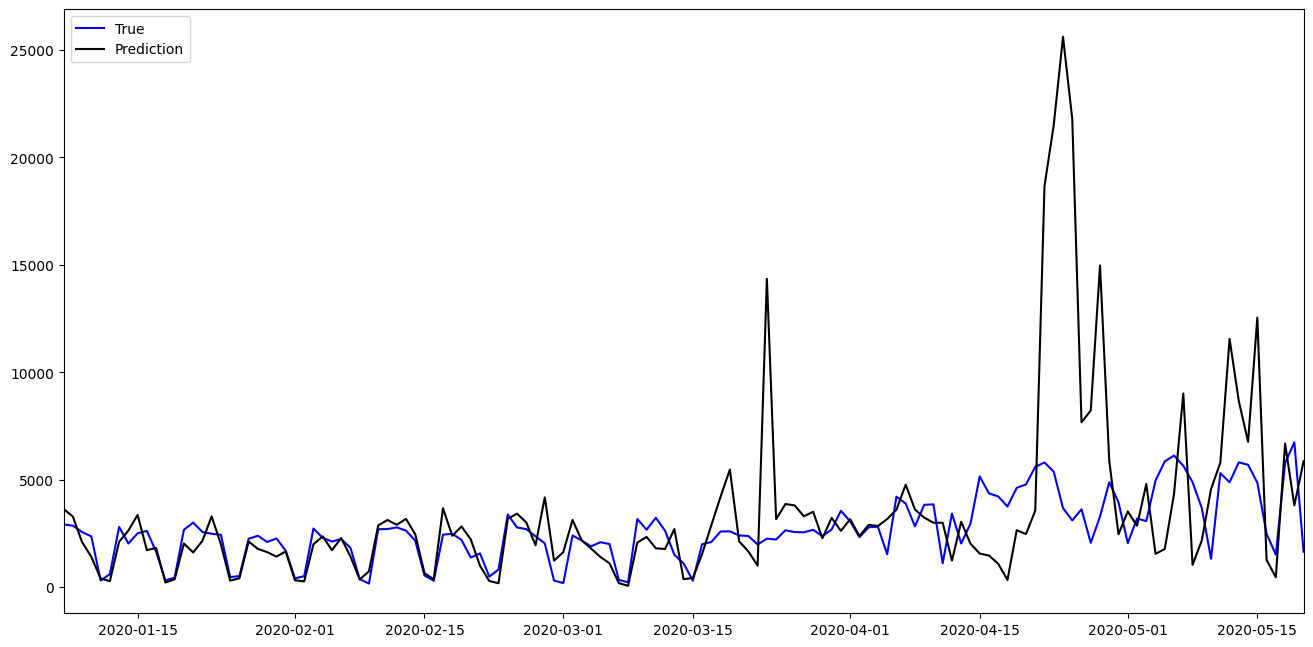

In [42]:
plot_prediction_vs_true(yhat=predictions, ytest=y_test)

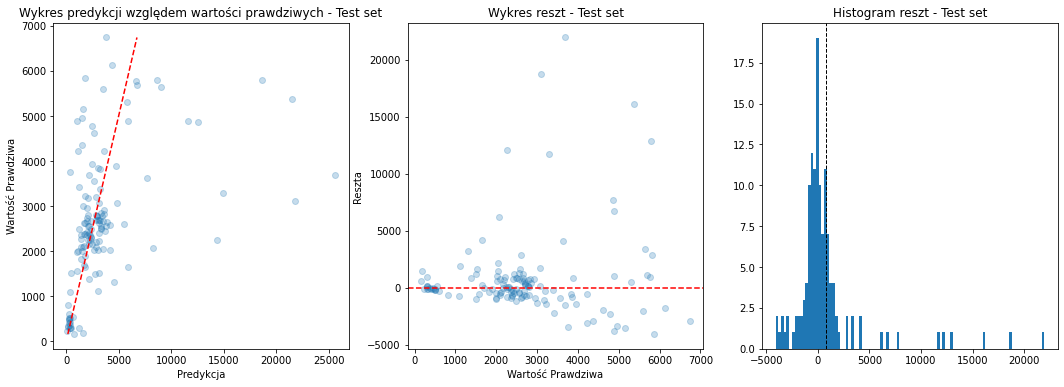

RMSE Test: 3788.829304571999
Pomniejszony zysk: 860863.0


In [43]:
model_evaluation(yhat=predictions, ytest=y_test)

## 3. Uogólniony Model Addytywny - Prophet

In [44]:
dataframe_prophet = dataframe_prepared.copy()
dataframe_prophet.reset_index(inplace=True)
dataframe_prophet.rename({'index': 'ds', 'Volume': 'y'}, axis=1, inplace=True)
dataframe_prophet

,ds,y,Rain,Temp
0,2016-11-17,933.0,9.0,2.1
1,2016-11-18,1197.0,6.7,3.9
2,2016-11-19,243.0,5.4,2.0
3,2016-11-20,234.0,3.9,2.8
4,2016-11-21,2148.0,7.3,2.8
...,...,...,...,...
1276,2020-05-16,2484.0,0.0,6.6
1277,2020-05-17,1509.0,0.0,9.1
1278,2020-05-18,5775.0,0.0,9.3
1279,2020-05-19,6741.0,0.0,9.7


In [45]:
train_prophet = dataframe_prophet.loc[dataframe_prophet['ds']<first_test_date].reset_index(drop=True).copy()
display(train_prophet)
cutoffs = pd.to_datetime(['2018-01-01', '2018-04-01', '2018-08-01', '2019-01-01', '2019-04-01', '2019-08-01'])
rmses_prophet = []

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 1],
    'seasonality_prior_scale':[0.01, 0.1, 1],
    'weekly_seasonality': [True]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    m.add_country_holidays(country_name='NO')
    m.add_regressor('Rain')
    m.add_regressor('Temp')
    m.fit(train_prophet)
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='120 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses_prophet.append(df_p['rmse'].values[0])
print('Holidays:')
print(m.train_holiday_names)
best_params = all_params[np.argmin(rmses_prophet)]
print('Best params:')
print(best_params)
print('RMSEs:')
print(rmses_prophet)

,ds,y,Rain,Temp
0,2016-11-17,933.0,9.0,2.1
1,2016-11-18,1197.0,6.7,3.9
2,2016-11-19,243.0,5.4,2.0
3,2016-11-20,234.0,3.9,2.8
4,2016-11-21,2148.0,7.3,2.8
...,...,...,...,...
1135,2019-12-27,342.0,0.0,-4.9
1136,2019-12-28,63.0,0.0,-1.2
1137,2019-12-29,126.0,5.9,4.4
1138,2019-12-30,558.0,0.0,5.5


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001A54A62A148>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001A54BB4DC08>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001A54A631348>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001A54A536348>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet

Holidays:
0                    Søndag
1           Første påskedag
2           Arbeidernes dag
3           Første pinsedag
4            Første juledag
5         Første nyttårsdag
6              Grunnlovsdag
7             Andre juledag
8              Skjærtorsdag
9                Langfredag
10           Andre påskedag
11    Kristi himmelfartsdag
12           Andre pinsedag
dtype: object
Best params:
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'weekly_seasonality': True}
RMSEs:
[1147.0031728800948, 1068.9492890739803, 1069.8951362705761, 1391.1770006789816, 1115.9330676341474, 1110.3191193378311, 2108.732247107887, 1392.1967830684612, 1318.9834081399868]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


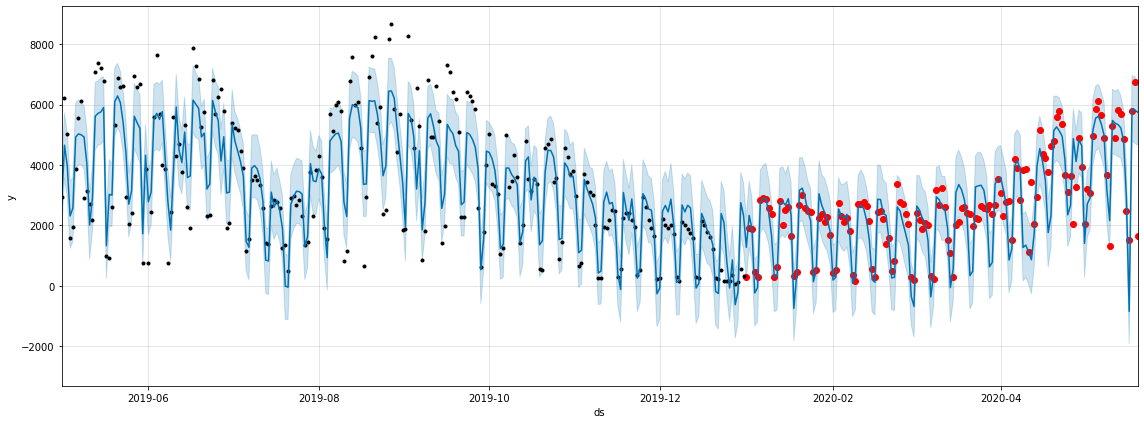

In [46]:
model_prophet = Prophet(**best_params)
model_prophet.add_country_holidays(country_name='NO')
model_prophet.add_regressor('Rain')
model_prophet.add_regressor('Temp')
model_prophet.fit(train_prophet)

# Predict on test set
total_prediction = model_prophet.predict(dataframe_prophet)

fig = plot(model_prophet, total_prediction, figsize=(16, 6))
plt.scatter(dataframe_prophet.loc[dataframe_prophet['ds']>='2020-01-01', 'ds'],
            dataframe_prophet.loc[dataframe_prophet['ds']>='2020-01-01', 'y'], color='red')
plt.xlim([total_prediction.loc[total_prediction['ds']>='2019-05-01', 'ds'].min(), total_prediction['ds'].max()])
plt.show()

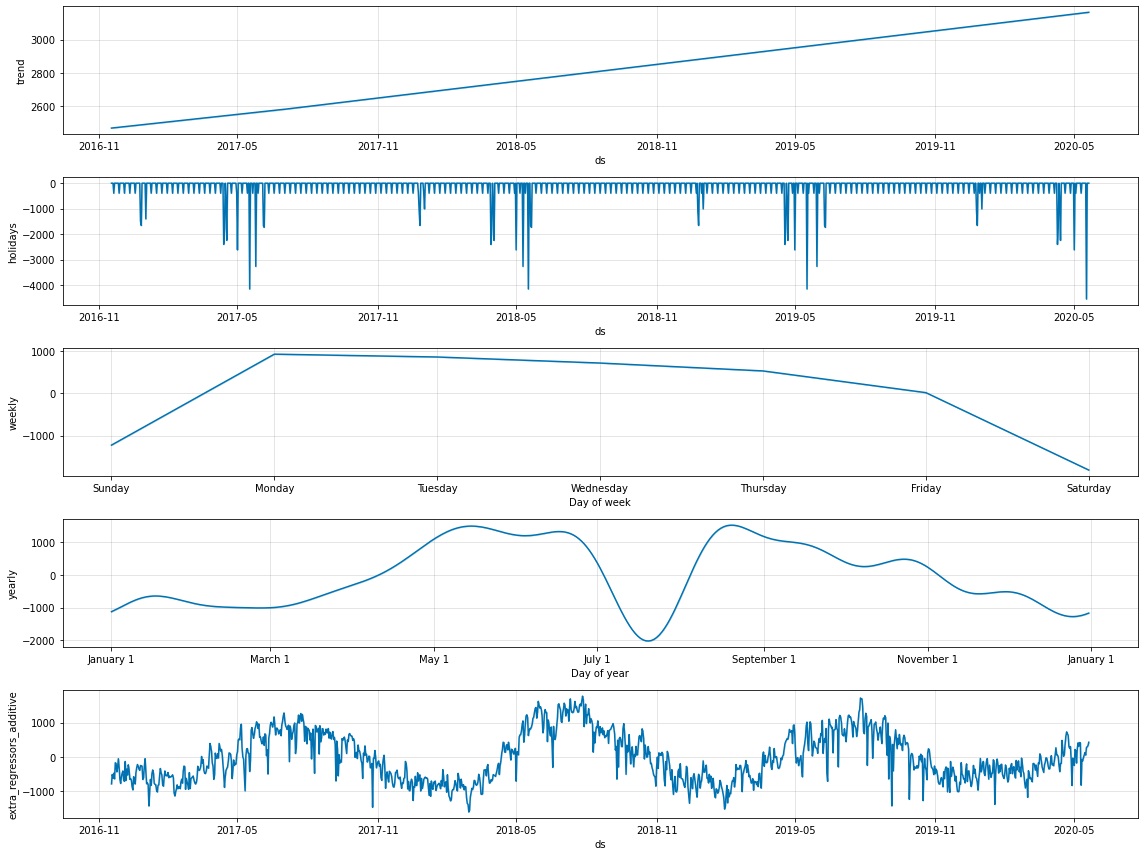

In [47]:
fig2 = model_prophet.plot_components(total_prediction, figsize=(16, 12))
plt.show()

In [48]:
training_periods = train_prophet.shape[0]

model_prophet_v2 = Prophet(**best_params)
model_prophet_v2.add_country_holidays(country_name='NO')
model_prophet_v2.add_regressor('Rain')
model_prophet_v2.add_regressor('Temp')
model_prophet_v2.fit(dataframe_prophet)

cross_val_score = cross_validation(model_prophet_v2, initial=f'{training_periods-1} Days', period='1 Day', horizon='1 W',
                                   parallel='processes')
predictions_prophet = cross_val_score.copy()
predictions_prophet.drop_duplicates(subset='cutoff', keep='last', inplace=True)
predictions_prophet.index = predictions_prophet['ds']
predictions_prophet.loc[predictions_prophet['yhat']<0, 'yhat']= 0
predictions_prophet = predictions_prophet['yhat']
predictions_prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 135 forecasts with cutoffs between 2019-12-31 00:00:00 and 2020-05-13 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001A54A39F2C8>


ds
2020-01-07    2883.383503
2020-01-08    2889.758444
2020-01-09    2410.142146
2020-01-10    1658.338954
2020-01-11     296.062922
                 ...     
2020-05-16    2991.646666
2020-05-17       0.000000
2020-05-18    5804.049851
2020-05-19    5803.270528
2020-05-20    5734.732051
Name: yhat, Length: 135, dtype: float64

Prognoza a wartość prawdziwa

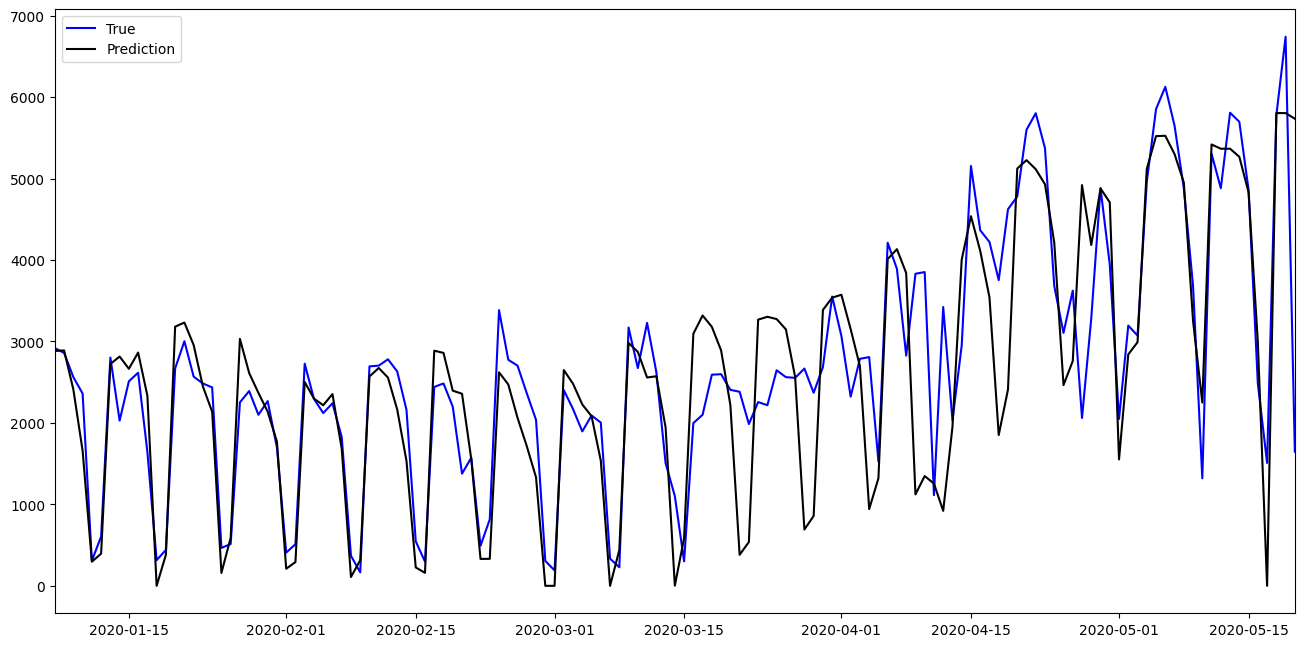

In [49]:
plot_prediction_vs_true(yhat=predictions_prophet, ytest=y_test)

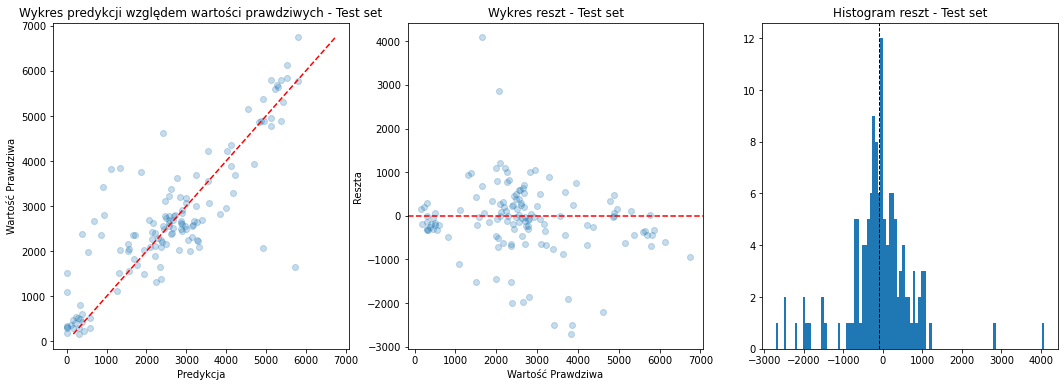

RMSE Test: 862.2166094508952
Pomniejszony zysk: 474810.0


In [50]:
model_evaluation(yhat=predictions_prophet, ytest=y_test)

## 4. Model Uczenia Maszynowego - ML
#### Przekształcenie problemu szeregu czasowego do problemu uczenia nadzorowanego

In [51]:
# Feature Engineering
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, future_variables_list):
        self.future_variables_list = future_variables_list
    
    def fit( self, X, y = None ):
        def dummies_weekday(X, column):
            dummies = pd.get_dummies(X[column], prefix=column)
            return dummies.columns
        
        X_copy = X.copy()
        X_copy['weekday'] = X_copy.index.weekday
        
        # Dzień tygodnia
        self.week_days_columns = dummies_weekday(X = X_copy, column = 'weekday')
        
        return self 
    
    def transform( self, X, y = None ):
        def encode_time(X, col, max_val):
            X[col + '_sin'] = np.sin(2 * np.pi * X[col]/max_val)
            X[col + '_cos'] = np.cos(2 * np.pi * X[col]/max_val)
            X.drop(col, axis='columns', inplace=True)
            return X
        
        def create_dummies(X, column, dummies_columns):
            dummies = pd.get_dummies(X[column], prefix=column)
            dummies = dummies.reindex(columns = dummies_columns, fill_value=0)
            X = pd.concat([X, dummies], axis=1)
            X.drop(column, axis='columns', inplace=True)
            return X
        
        X_transformed = X.copy()
        
        future_variables_list = []
        
        # Zmienne z przyszłości
        for horizon in range(1, 8):
            # Zmienne objaśniane
            X_transformed[f'Volume_horizon_{horizon}W'] = X_transformed['Volume'].shift(-horizon)
            future_variables_list.append(f'Volume_horizon_{horizon}W')
            
            # Zmienne znane z przyszłości
            for future_variable in self.future_variables_list:
                X_transformed[f'{future_variable}_horizon_{horizon}W'] = X_transformed[future_variable].shift(-horizon)
                future_variables_list.append(f'{future_variable}_horizon_{horizon}W')
        
        
        # Zmienne z przeszłości:
        X_transformed.rename({'Volume': 'Volume_lag_1'}, axis=1, inplace=True)
        
        # Opóźnione wartości
        for lag in range(1, 13):
            X_transformed[f'Volume_lag_{lag+1}W'] = X_transformed['Volume_lag_1'].shift(lag)
        
        # Kroczące statystyki
        for window in [7, 14]:
            X_transformed[f'Volume_window_{window}_mean'] = X_transformed['Volume_lag_1'].rolling(window=window).mean()
            X_transformed[f'Volume_window_{window}_std'] = X_transformed['Volume_lag_1'].rolling(window=window).std()
            X_transformed[f'Volume_window_{window}_min'] = X_transformed['Volume_lag_1'].rolling(window=window).min()
            X_transformed[f'Volume_window_{window}_max'] = X_transformed['Volume_lag_1'].rolling(window=window).max()
        
        # Dzień w roku - sezonowość
        # date
        X_transformed['day_of_year'] = X_transformed.index.dayofyear
        X_transformed = encode_time(X_transformed, 'day_of_year', 366)
        
        
        # Dień tygodnia
        X_transformed['weekday'] = X_transformed.index.weekday
        X_transformed = create_dummies(X = X_transformed, column = 'weekday', dummies_columns = self.week_days_columns)
        
        # Usunięcie niepotrzebnych zmiennych
        X_transformed.drop(['Rain', 'Temp'], axis=1, inplace=True)
        
        # Usunięcie wierszy z brakującymi danymi
        X_transformed.dropna(subset=[ele for ele in list(X_transformed.columns) if ele not in future_variables_list],
                             inplace=True)
        
        return X_transformed

In [52]:
future_variables = ['Rain', 'Temp']

steps_feature_engineering = [
    ('feature_engineering_transformer', FeatureEngineeringTransformer(future_variables_list=future_variables))
]

pipeline_feature_engineering = Pipeline(steps = steps_feature_engineering)
pipeline_feature_engineering.fit_transform(dataframe_prepared)

,Volume_lag_1,Volume_horizon_1W,Rain_horizon_1W,Temp_horizon_1W,Volume_horizon_2W,Rain_horizon_2W,Temp_horizon_2W,Volume_horizon_3W,Rain_horizon_3W,Temp_horizon_3W,...,Volume_window_14_max,day_of_year_sin,day_of_year_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2016-11-30,1908.0,1620.0,0.0,0.7,1464.0,0.0,1.4,213.0,0.0,-1.7,...,2175.0,-0.507415,0.861702,0,0,1,0,0,0,0
2016-12-01,1620.0,1464.0,0.0,1.4,213.0,0.0,-1.7,246.0,0.0,-2.0,...,2175.0,-0.492548,0.870285,0,0,0,1,0,0,0
2016-12-02,1464.0,213.0,0.0,-1.7,246.0,0.0,-2.0,2079.0,0.0,4.5,...,2175.0,-0.477536,0.878612,0,0,0,0,1,0,0
2016-12-03,213.0,246.0,0.0,-2.0,2079.0,0.0,4.5,1860.0,0.0,-1.7,...,2175.0,-0.462383,0.886680,0,0,0,0,0,1,0
2016-12-04,246.0,2079.0,0.0,4.5,1860.0,0.0,-1.7,1539.0,0.0,2.0,...,2175.0,-0.447094,0.894487,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-16,2484.0,1509.0,0.0,9.1,5775.0,0.0,9.3,6741.0,0.0,9.7,...,6126.0,0.710135,-0.704066,0,0,0,0,0,1,0
2020-05-17,1509.0,5775.0,0.0,9.3,6741.0,0.0,9.7,1647.0,0.0,10.8,...,6126.0,0.697944,-0.716152,0,0,0,0,0,0,1
2020-05-18,5775.0,6741.0,0.0,9.7,1647.0,0.0,10.8,NaN,NaN,NaN,...,6126.0,0.685548,-0.728028,1,0,0,0,0,0,0
2020-05-19,6741.0,1647.0,0.0,10.8,NaN,NaN,NaN,NaN,NaN,NaN,...,6741.0,0.672949,-0.739689,0,1,0,0,0,0,0


In [53]:
target_columns = [f'Volume_horizon_{horizon}W' for horizon in range(1, 8)]
target_columns

['Volume_horizon_1W',
 'Volume_horizon_2W',
 'Volume_horizon_3W',
 'Volume_horizon_4W',
 'Volume_horizon_5W',
 'Volume_horizon_6W',
 'Volume_horizon_7W']

In [54]:
future_variables_columns = [f'Rain_horizon_{horizon}W' for horizon in range(1, 8)]+\
                           [f'Temp_horizon_{horizon}W' for horizon in range(1, 8)]
future_variables_columns

['Rain_horizon_1W',
 'Rain_horizon_2W',
 'Rain_horizon_3W',
 'Rain_horizon_4W',
 'Rain_horizon_5W',
 'Rain_horizon_6W',
 'Rain_horizon_7W',
 'Temp_horizon_1W',
 'Temp_horizon_2W',
 'Temp_horizon_3W',
 'Temp_horizon_4W',
 'Temp_horizon_5W',
 'Temp_horizon_6W',
 'Temp_horizon_7W']

In [55]:
print('Creating a training set')
train_set_ml = pipeline_feature_engineering.fit_transform(dataframe_prepared.loc[
                                                        dataframe_prepared.index<=(first_test_date-dt.timedelta(days=1)), :])
X_train_ml = train_set_ml.drop(target_columns, axis = 1).copy()
y_train_ml = train_set_ml[target_columns].copy()

print('\nCreating a test set')
test_set_ml = pipeline_feature_engineering.fit_transform(dataframe_prepared)
test_set_ml = test_set_ml.loc[test_set_ml.index>=(first_test_date-dt.timedelta(days=1)), :]
X_test_ml = test_set_ml.drop(target_columns, axis = 1).copy()
print('\nDone')

Creating a training set

Creating a test set

Done


In [56]:
X_train_ml

,Volume_lag_1,Rain_horizon_1W,Temp_horizon_1W,Rain_horizon_2W,Temp_horizon_2W,Rain_horizon_3W,Temp_horizon_3W,Rain_horizon_4W,Temp_horizon_4W,Rain_horizon_5W,...,Volume_window_14_max,day_of_year_sin,day_of_year_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2016-11-30,1908.0,0.0,0.7,0.0,1.4,0.0,-1.7,0.0,-2.0,0.0,...,2175.0,-0.507415,0.861702,0,0,1,0,0,0,0
2016-12-01,1620.0,0.0,1.4,0.0,-1.7,0.0,-2.0,0.0,4.5,0.0,...,2175.0,-0.492548,0.870285,0,0,0,1,0,0,0
2016-12-02,1464.0,0.0,-1.7,0.0,-2.0,0.0,4.5,0.0,-1.7,0.0,...,2175.0,-0.477536,0.878612,0,0,0,0,1,0,0
2016-12-03,213.0,0.0,-2.0,0.0,4.5,0.0,-1.7,0.0,2.0,10.3,...,2175.0,-0.462383,0.886680,0,0,0,0,0,1,0
2016-12-04,246.0,0.0,4.5,0.0,-1.7,0.0,2.0,10.3,5.7,0.0,...,2175.0,-0.447094,0.894487,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,342.0,0.0,-1.2,5.9,4.4,0.0,5.5,0.0,1.1,NaN,...,2148.0,-0.085731,0.996318,0,0,0,0,1,0,0
2019-12-28,63.0,5.9,4.4,0.0,5.5,0.0,1.1,NaN,NaN,NaN,...,2148.0,-0.068615,0.997643,0,0,0,0,0,1,0
2019-12-29,126.0,0.0,5.5,0.0,1.1,NaN,NaN,NaN,NaN,NaN,...,2148.0,-0.051479,0.998674,0,0,0,0,0,0,1
2019-12-30,558.0,0.0,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2025.0,-0.034328,0.999411,1,0,0,0,0,0,0


In [57]:
y_train_ml

,Volume_horizon_1W,Volume_horizon_2W,Volume_horizon_3W,Volume_horizon_4W,Volume_horizon_5W,Volume_horizon_6W,Volume_horizon_7W
2016-11-30,1620.0,1464.0,213.0,246.0,2079.0,1860.0,1539.0
2016-12-01,1464.0,213.0,246.0,2079.0,1860.0,1539.0,1743.0
2016-12-02,213.0,246.0,2079.0,1860.0,1539.0,1743.0,1608.0
2016-12-03,246.0,2079.0,1860.0,1539.0,1743.0,1608.0,261.0
2016-12-04,2079.0,1860.0,1539.0,1743.0,1608.0,261.0,354.0
...,...,...,...,...,...,...,...
2019-12-27,63.0,126.0,558.0,315.0,NaN,NaN,NaN
2019-12-28,126.0,558.0,315.0,NaN,NaN,NaN,NaN
2019-12-29,558.0,315.0,NaN,NaN,NaN,NaN,NaN
2019-12-30,315.0,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
X_test_ml

,Volume_lag_1,Rain_horizon_1W,Temp_horizon_1W,Rain_horizon_2W,Temp_horizon_2W,Rain_horizon_3W,Temp_horizon_3W,Rain_horizon_4W,Temp_horizon_4W,Rain_horizon_5W,...,Volume_window_14_max,day_of_year_sin,day_of_year_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2019-12-31,315.0,0.0,1.9,0.0,4.1,0.0,4.5,0.1,0.7,0.0,...,1791.0,-0.017166,0.999853,0,1,0,0,0,0,0
2020-01-01,300.0,0.0,4.1,0.0,4.5,0.1,0.7,0.0,-0.1,0.4,...,1623.0,0.017166,0.999853,0,0,1,0,0,0,0
2020-01-02,1914.0,0.0,4.5,0.1,0.7,0.0,-0.1,0.4,2.7,0.0,...,1914.0,0.034328,0.999411,0,0,0,1,0,0,0
2020-01-03,1878.0,0.1,0.7,0.0,-0.1,0.4,2.7,0.0,4.5,0.5,...,1914.0,0.051479,0.998674,0,0,0,0,1,0,0
2020-01-04,456.0,0.0,-0.1,0.4,2.7,0.0,4.5,0.5,5.7,0.0,...,1914.0,0.068615,0.997643,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-16,2484.0,0.0,9.1,0.0,9.3,0.0,9.7,0.0,10.8,NaN,...,6126.0,0.710135,-0.704066,0,0,0,0,0,1,0
2020-05-17,1509.0,0.0,9.3,0.0,9.7,0.0,10.8,NaN,NaN,NaN,...,6126.0,0.697944,-0.716152,0,0,0,0,0,0,1
2020-05-18,5775.0,0.0,9.7,0.0,10.8,NaN,NaN,NaN,NaN,NaN,...,6126.0,0.685548,-0.728028,1,0,0,0,0,0,0
2020-05-19,6741.0,0.0,10.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6741.0,0.672949,-0.739689,0,1,0,0,0,0,0


#### Trenowanie iteracyjne modeli

#### Trenowanie pojedynczego modelu

In [59]:
class FeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, feature_to_delete):
        self.feature_to_delete = feature_to_delete
        pass
        
        
    def fit(self, X, y = None):
        return self
    
    def transform( self, X, y = None ):
        df_features = X.copy()
        
        df_features = df_features.loc[:, ~df_features.columns.isin(self.feature_to_delete)]
        df_features.dropna(inplace=True)
        
        return df_features

|---------------------------	Volume_horizon_1W	---------------------------|
1
Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best estimator: 
Pipeline(steps=[('feature_selection',
                 FeatureSelection(feature_to_delete=['Rain_horizon_2W',
                                                     'Rain_horizon_3W',
                                                     'Rain_horizon_4W',
                                                     'Rain_horizon_5W',
                                                     'Rain_horizon_6W',
                                                     'Rain_horizon_7W',
                                                     'Temp_horizon_2W',
                                                     'Temp_horizon_3W',
                                                     'Temp_horizon_4W',
                                                     'Temp_horizon_5W',
                                                     'Temp_horizon_6W',
           

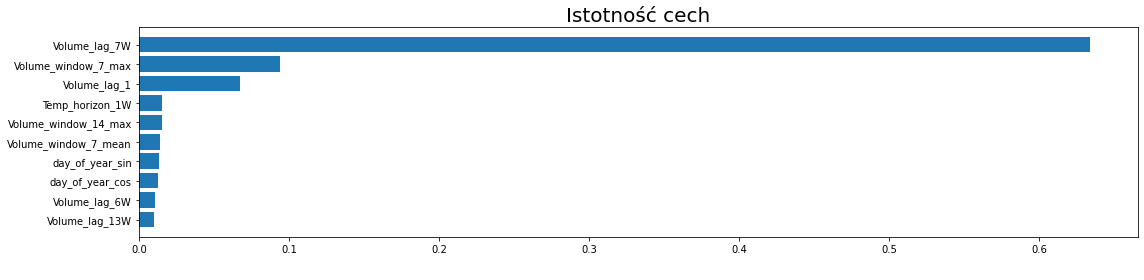

Iteracja zakończona w: 60 sekundach


|---------------------------	Volume_horizon_2W	---------------------------|
2
Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best estimator: 
Pipeline(steps=[('feature_selection',
                 FeatureSelection(feature_to_delete=['Rain_horizon_1W',
                                                     'Rain_horizon_3W',
                                                     'Rain_horizon_4W',
                                                     'Rain_horizon_5W',
                                                     'Rain_horizon_6W',
                                                     'Rain_horizon_7W',
                                                     'Temp_horizon_1W',
                                                     'Temp_horizon_3W',
                                                     'Temp_horizon_4W',
                                                     'Temp_horizon_5W',
                                             

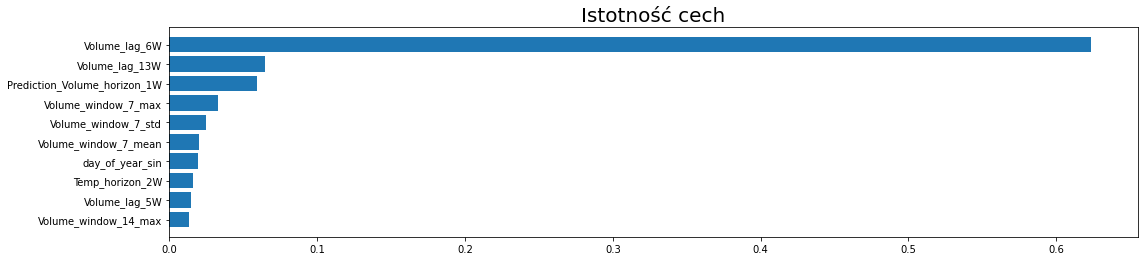

Iteracja zakończona w: 52 sekundach


|---------------------------	Volume_horizon_3W	---------------------------|
3
Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best estimator: 
Pipeline(steps=[('feature_selection',
                 FeatureSelection(feature_to_delete=['Rain_horizon_1W',
                                                     'Rain_horizon_2W',
                                                     'Rain_horizon_4W',
                                                     'Rain_horizon_5W',
                                                     'Rain_horizon_6W',
                                                     'Rain_horizon_7W',
                                                     'Temp_horizon_1W',
                                                     'Temp_horizon_2W',
                                                     'Temp_horizon_4W',
                                                     'Temp_horizon_5W',
                                             

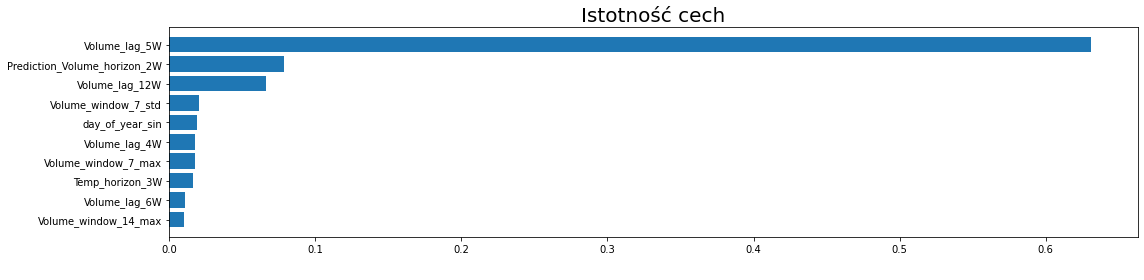

Iteracja zakończona w: 53 sekundach


|---------------------------	Volume_horizon_4W	---------------------------|
4
Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best estimator: 
Pipeline(steps=[('feature_selection',
                 FeatureSelection(feature_to_delete=['Rain_horizon_1W',
                                                     'Rain_horizon_2W',
                                                     'Rain_horizon_3W',
                                                     'Rain_horizon_5W',
                                                     'Rain_horizon_6W',
                                                     'Rain_horizon_7W',
                                                     'Temp_horizon_1W',
                                                     'Temp_horizon_2W',
                                                     'Temp_horizon_3W',
                                                     'Temp_horizon_5W',
                                             

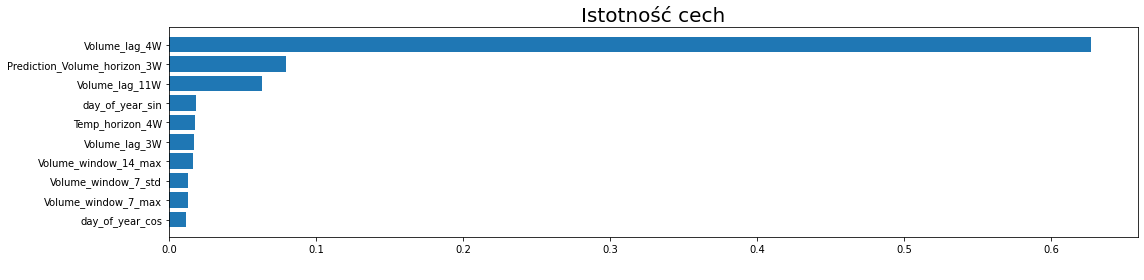

Iteracja zakończona w: 57 sekundach


|---------------------------	Volume_horizon_5W	---------------------------|
5
Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best estimator: 
Pipeline(steps=[('feature_selection',
                 FeatureSelection(feature_to_delete=['Rain_horizon_1W',
                                                     'Rain_horizon_2W',
                                                     'Rain_horizon_3W',
                                                     'Rain_horizon_4W',
                                                     'Rain_horizon_6W',
                                                     'Rain_horizon_7W',
                                                     'Temp_horizon_1W',
                                                     'Temp_horizon_2W',
                                                     'Temp_horizon_3W',
                                                     'Temp_horizon_4W',
                                             

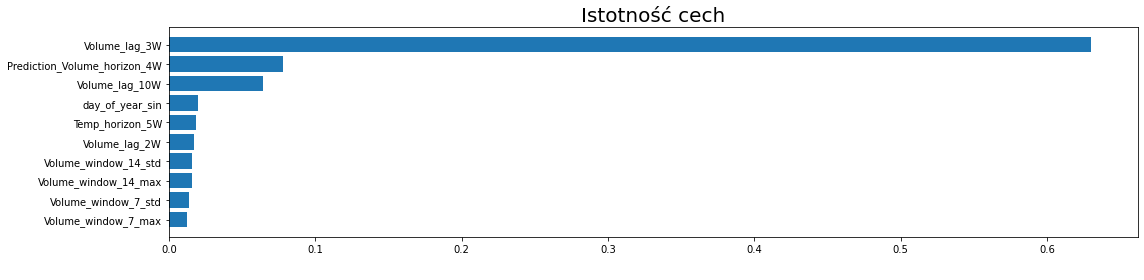

Iteracja zakończona w: 57 sekundach


|---------------------------	Volume_horizon_6W	---------------------------|
6
Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best estimator: 
Pipeline(steps=[('feature_selection',
                 FeatureSelection(feature_to_delete=['Rain_horizon_1W',
                                                     'Rain_horizon_2W',
                                                     'Rain_horizon_3W',
                                                     'Rain_horizon_4W',
                                                     'Rain_horizon_5W',
                                                     'Rain_horizon_7W',
                                                     'Temp_horizon_1W',
                                                     'Temp_horizon_2W',
                                                     'Temp_horizon_3W',
                                                     'Temp_horizon_4W',
                                             

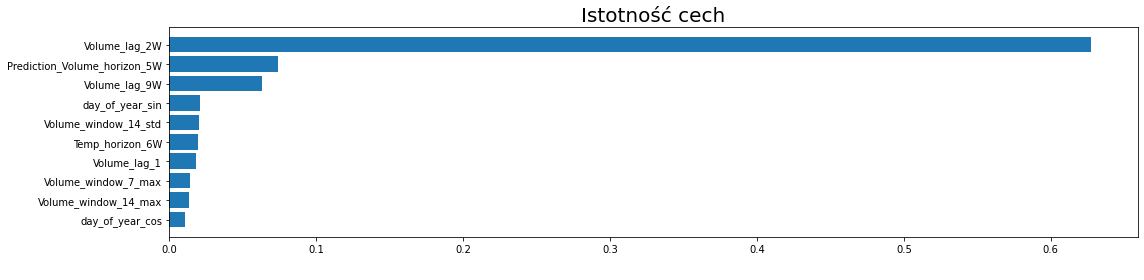

Iteracja zakończona w: 59 sekundach


|---------------------------	Volume_horizon_7W	---------------------------|
7
Fitting 5 folds for each of 9 candidates, totalling 45 fits
The best estimator: 
Pipeline(steps=[('feature_selection',
                 FeatureSelection(feature_to_delete=['Rain_horizon_1W',
                                                     'Rain_horizon_2W',
                                                     'Rain_horizon_3W',
                                                     'Rain_horizon_4W',
                                                     'Rain_horizon_5W',
                                                     'Rain_horizon_6W',
                                                     'Temp_horizon_1W',
                                                     'Temp_horizon_2W',
                                                     'Temp_horizon_3W',
                                                     'Temp_horizon_4W',
                                             

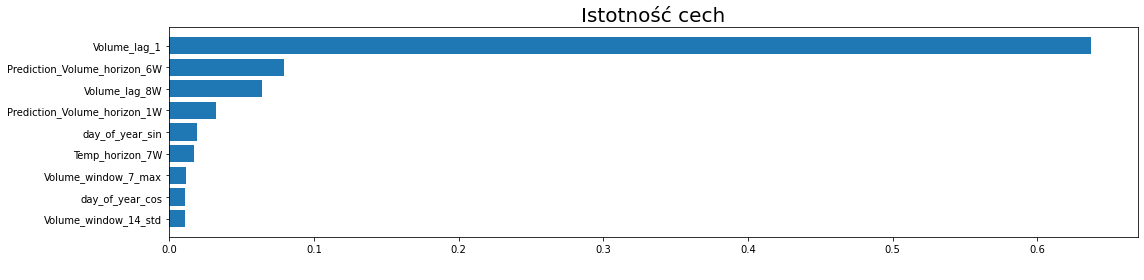

Iteracja zakończona w: 59 sekundach




In [60]:
for horizon_prediction in target_columns:
    start_time = time.time()
    print(f'|---------------------------\t{horizon_prediction}\t---------------------------|')
    ###################### Selekcja zmiennych z przyszłości ######################
    horizon_number = int(horizon_prediction[-2:-1])
    print(horizon_number)
    future_variables_not_selected = filter(lambda feature: feature != f'Rain_horizon_{horizon_number}W',
                                           future_variables_columns)
    future_variables_not_selected = filter(lambda feature: feature != f'Temp_horizon_{horizon_number}W',
                                           future_variables_not_selected)
    future_variables_not_selected = list(future_variables_not_selected)
    
    ###################### Przygotowanie danych Train i Test ######################
    # Train
    y_train_single_horizon = y_train_ml[horizon_prediction].copy()
    X_train_single_horizon = X_train_ml.loc[~y_train_single_horizon.isnull(),
                                            :].copy()
    y_train_single_horizon.dropna(inplace=True)
    # Test
    X_test_single_horizon = X_test_ml.copy()
    
    ###################### Optymalizacja hiperparametrów ######################
    random_forest_pipeline = Pipeline(steps=[('feature_selection', FeatureSelection(future_variables_not_selected)),
                                             ('regressor', RandomForestRegressor(random_state=123))])
    
    param_random_forest = {
        'regressor__max_depth': [10, 15, 20],
        'regressor__min_samples_leaf': [2, 3, 5],
        'regressor__n_estimators': [500],
        'regressor__criterion': ['mse'],
    }
    
    random_forest = GridSearchCV(random_forest_pipeline, param_random_forest, 
                                 cv=TimeSeriesSplit(n_splits=5).split(X_train_single_horizon), n_jobs=-1, 
                                 scoring = 'neg_mean_squared_error', verbose=10)
    random_forest.fit(X_train_single_horizon, y_train_single_horizon)
    print("The best estimator: ", random_forest.best_estimator_,
          "\nThe best score: ", random_forest.best_score_,
          "\nThe best parameters: ", random_forest.best_params_, sep="\n")
    
    random_forest_model = random_forest.best_estimator_
    
    # Feature Importance
    importance = random_forest_model._final_estimator.feature_importances_
    df_feature_importance=importance.argsort()
    df_feature_importance=pd.DataFrame({
        'column':FeatureSelection(future_variables_not_selected).fit_transform(X_train_single_horizon).columns[
                                                                                                        df_feature_importance],
        'importance':importance[df_feature_importance]
    })
    df_feature_importance = df_feature_importance[df_feature_importance['importance']>=0.01].copy().reset_index(drop=True)
    plt.figure(figsize=(16, 4))
    plt.barh(df_feature_importance['column'][-10:], df_feature_importance['importance'][-10:])
    plt.tick_params(axis='both', labelsize=10)
    plt.title('Istotność cech', size=20)
    plt.xlabel(' ', size=15)
    plt.tight_layout()
    plt.show()
    
    
    X_train_ml[f'Prediction_{horizon_prediction}'] = random_forest_model.predict(X_train_ml.fillna(0))
    X_test_ml[f'Prediction_{horizon_prediction}'] = random_forest_model.predict(X_test_ml.fillna(0))
    
    elapsed_time = time.time() - start_time
    print("Iteracja zakończona w: " + str(int(elapsed_time))  + " sekundach")
    print('\n')

In [61]:
predictions_ml = X_test_ml['Prediction_Volume_horizon_7W'].copy()
predictions_ml.index += dt.timedelta(days=7)
predictions_ml = predictions_ml[predictions_ml.index<=y_test.index.max()]
predictions_ml

2020-01-07    1119.071258
2020-01-08     841.615264
2020-01-09    1439.662269
2020-01-10    1560.918771
2020-01-11    1045.208844
                 ...     
2020-05-16    3544.548046
2020-05-17    2654.831372
2020-05-18    4399.596993
2020-05-19    4527.181904
2020-05-20    4844.071228
Freq: D, Name: Prediction_Volume_horizon_7W, Length: 135, dtype: float64

Prognoza a wartość prawdziwa

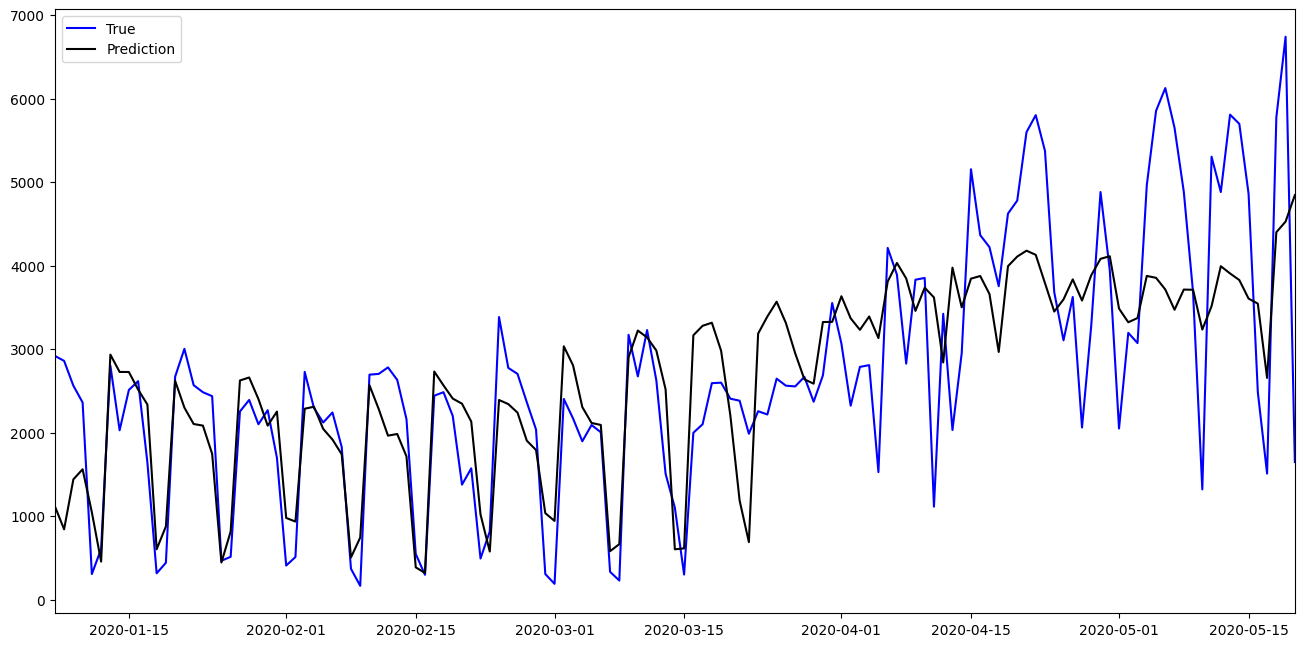

In [62]:
plot_prediction_vs_true(yhat=predictions_ml, ytest=y_test)

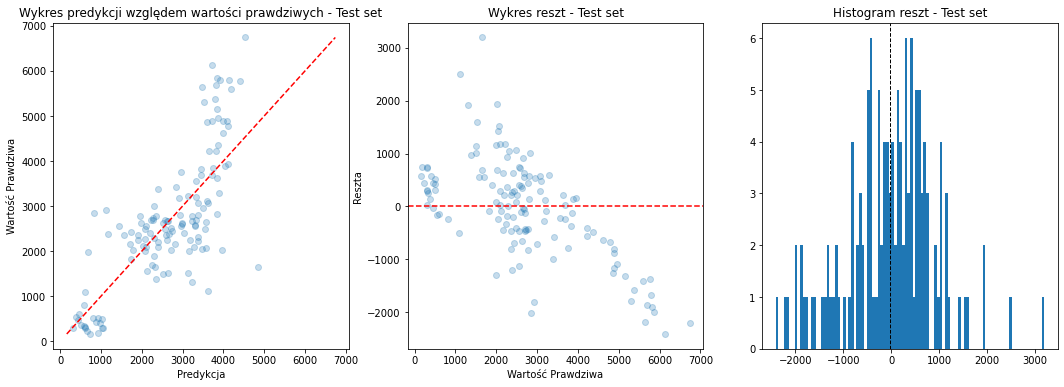

RMSE Test: 945.8136506433146
Pomniejszony zysk: 551324.0


In [63]:
model_evaluation(yhat=predictions_ml, ytest=y_test)

## 5. Rekurencyjna sieć neuronowa

In [64]:
# Feature Engineering
class FeatureEngineeringTransformer_v2(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit( self, X, y = None ):
        def dummies_weekday(X, column):
            dummies = pd.get_dummies(X[column], prefix=column)
            return dummies.columns
        
        X_copy = X.copy()
        X_copy['weekday'] = X_copy.index.weekday
        
        # Dzień tygodnia
        self.week_days_columns = dummies_weekday(X = X_copy, column = 'weekday')
        
        return self 
    
    def transform( self, X, y = None ):
        def encode_time(X, col, max_val):
            X[col + '_sin'] = np.sin(2 * np.pi * X[col]/max_val)
            X[col + '_cos'] = np.cos(2 * np.pi * X[col]/max_val)
            X.drop(col, axis='columns', inplace=True)
            return X
        
        def create_dummies(X, column, dummies_columns):
            dummies = pd.get_dummies(X[column], prefix=column)
            dummies = dummies.reindex(columns = dummies_columns, fill_value=0)
            X = pd.concat([X, dummies], axis=1)
            X.drop(column, axis='columns', inplace=True)
            return X
        
        X_transformed = X.copy()
        
        # Przesunięcie zmiennych z przyszłości
        X_transformed['Rain'] = X_transformed['Rain'].shift(-7)
        X_transformed['Temp'] = X_transformed['Temp'].shift(-7)
        
        # Dzień w roku - sezonowość
        # date
        X_transformed['day_of_year'] = X_transformed.index.dayofyear
        X_transformed = encode_time(X_transformed, 'day_of_year', 366)
        
        
        # Dień tygodnia
        X_transformed['weekday'] = X_transformed.index.weekday
        X_transformed = create_dummies(X = X_transformed, column = 'weekday', dummies_columns = self.week_days_columns)
        
        return X_transformed

In [65]:
feature_transformer_rnn = FeatureEngineeringTransformer_v2()
dataframe_rnn = feature_transformer_rnn.fit_transform(dataframe_prepared)
dataframe_rnn.dropna(inplace=True)
dataframe_rnn

,Volume,Rain,Temp,day_of_year_sin,day_of_year_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2016-11-17,933.0,0.0,1.1,-0.685548,0.728028,0,0,0,1,0,0,0
2016-11-18,1197.0,1.0,3.1,-0.672949,0.739689,0,0,0,0,1,0,0
2016-11-19,243.0,0.0,5.4,-0.660152,0.751132,0,0,0,0,0,1,0
2016-11-20,234.0,0.0,2.6,-0.647161,0.762354,0,0,0,0,0,0,1
2016-11-21,2148.0,0.0,-1.3,-0.633978,0.773351,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-09,3681.0,0.0,6.6,0.789418,-0.613856,0,0,0,0,0,1,0
2020-05-10,1320.0,0.0,9.1,0.778764,-0.627317,0,0,0,0,0,0,1
2020-05-11,5304.0,0.0,9.3,0.767880,-0.640593,1,0,0,0,0,0,0
2020-05-12,4881.0,0.0,9.7,0.756771,-0.653680,0,1,0,0,0,0,0


In [66]:
train_rnn = dataframe_rnn[dataframe_rnn.index<'2019-07-01'].copy()
print('Train data:')
display(train_rnn)

val_rnn = dataframe_rnn[(dataframe_rnn.index>='2019-07-01')&(dataframe_rnn.index<first_test_date-dt.timedelta(days=14))].copy()
print('Validation data:')
display(val_rnn)

test_rnn = dataframe_rnn[dataframe_rnn.index>=(first_test_date-dt.timedelta(days=14))].copy()
print('Test data:')
display(test_rnn)

Train data:


,Volume,Rain,Temp,day_of_year_sin,day_of_year_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2016-11-17,933.0,0.0,1.1,-0.685548,0.728028,0,0,0,1,0,0,0
2016-11-18,1197.0,1.0,3.1,-0.672949,0.739689,0,0,0,0,1,0,0
2016-11-19,243.0,0.0,5.4,-0.660152,0.751132,0,0,0,0,0,1,0
2016-11-20,234.0,0.0,2.6,-0.647161,0.762354,0,0,0,0,0,0,1
2016-11-21,2148.0,0.0,-1.3,-0.633978,0.773351,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,6249.0,0.0,13.0,0.102821,-0.994700,0,0,1,0,0,0,0
2019-06-27,6519.0,0.0,12.9,0.085731,-0.996318,0,0,0,1,0,0,0
2019-06-28,5793.0,0.9,15.7,0.068615,-0.997643,0,0,0,0,1,0,0
2019-06-29,1923.0,0.0,13.5,0.051479,-0.998674,0,0,0,0,0,1,0


Validation data:


,Volume,Rain,Temp,day_of_year_sin,day_of_year_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2019-07-01,5406.0,4.7,16.4,1.716633e-02,-0.999853,1,0,0,0,0,0,0
2019-07-02,5217.0,0.0,17.4,1.224647e-16,-1.000000,0,1,0,0,0,0,0
2019-07-03,5163.0,0.0,19.5,-1.716633e-02,-0.999853,0,0,1,0,0,0,0
2019-07-04,4464.0,0.0,19.7,-3.432760e-02,-0.999411,0,0,0,1,0,0,0
2019-07-05,3915.0,0.0,18.9,-5.147875e-02,-0.998674,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-13,1596.0,4.9,2.4,-3.204233e-01,0.947274,0,0,0,0,1,0,0
2019-12-14,276.0,0.0,3.2,-3.041148e-01,0.952635,0,0,0,0,0,1,0
2019-12-15,243.0,2.7,2.1,-2.877168e-01,0.957716,0,0,0,0,0,0,1
2019-12-16,2148.0,0.0,2.0,-2.712339e-01,0.962513,1,0,0,0,0,0,0


Test data:


,Volume,Rain,Temp,day_of_year_sin,day_of_year_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2019-12-18,1791.0,1.3,-0.3,-0.238033,0.971257,0,0,1,0,0,0,0
2019-12-19,1623.0,0.0,-2.4,-0.221325,0.975200,0,0,0,1,0,0,0
2019-12-20,1209.0,0.0,-4.9,-0.204552,0.978856,0,0,0,0,1,0,0
2019-12-21,252.0,0.0,-1.2,-0.187719,0.982223,0,0,0,0,0,1,0
2019-12-22,225.0,5.9,4.4,-0.170830,0.985301,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-09,3681.0,0.0,6.6,0.789418,-0.613856,0,0,0,0,0,1,0
2020-05-10,1320.0,0.0,9.1,0.778764,-0.627317,0,0,0,0,0,0,1
2020-05-11,5304.0,0.0,9.3,0.767880,-0.640593,1,0,0,0,0,0,0
2020-05-12,4881.0,0.0,9.7,0.756771,-0.653680,0,1,0,0,0,0,0


In [67]:
train_mean = train_rnn.loc[:, 'Volume':'day_of_year_cos'].mean()
train_std = train_rnn.loc[:, 'Volume':'day_of_year_cos'].std()

train_rnn.loc[:, 'Volume':'day_of_year_cos'] = (train_rnn.loc[:, 'Volume':'day_of_year_cos'] - train_mean) / train_std
print('Train data:')
display(train_rnn)

val_rnn.loc[:, 'Volume':'day_of_year_cos'] = (val_rnn.loc[:, 'Volume':'day_of_year_cos'] - train_mean) / train_std
print('Validation data:')
display(val_rnn)

test_rnn.loc[:, 'Volume':'day_of_year_cos'] = (test_rnn.loc[:, 'Volume':'day_of_year_cos'] - train_mean) / train_std
print('Test data:')
display(test_rnn)

Train data:


,Volume,Rain,Temp,day_of_year_sin,day_of_year_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2016-11-17,-0.802346,-0.427071,-0.709882,-1.145592,0.959093,0,0,0,1,0,0,0
2016-11-18,-0.670251,-0.188882,-0.463361,-1.127333,0.975386,0,0,0,0,1,0,0
2016-11-19,-1.147593,-0.427071,-0.179862,-1.108787,0.991376,0,0,0,0,0,1,0
2016-11-20,-1.152096,-0.427071,-0.524991,-1.089959,1.007055,0,0,0,0,0,0,1
2016-11-21,-0.194411,-0.427071,-1.005707,-1.070854,1.022421,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-26,1.857557,-0.427071,0.756917,-0.003031,-1.448041,0,0,1,0,0,0,0
2019-06-27,1.992654,-0.427071,0.744591,-0.027800,-1.450302,0,0,0,1,0,0,0
2019-06-28,1.629394,-0.212701,1.089720,-0.052605,-1.452153,0,0,0,0,1,0,0
2019-06-29,-0.306992,-0.427071,0.818547,-0.077440,-1.453594,0,0,0,0,0,1,0


Validation data:


,Volume,Rain,Temp,day_of_year_sin,day_of_year_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2019-07-01,1.435755,0.692418,1.176002,-0.127168,-1.455240,1,0,0,0,0,0,0
2019-07-02,1.341187,-0.427071,1.299262,-0.152047,-1.455446,0,1,0,0,0,0,0
2019-07-03,1.314168,-0.427071,1.558109,-0.176926,-1.455240,0,0,1,0,0,0,0
2019-07-04,0.964418,-0.427071,1.582761,-0.201797,-1.454623,0,0,0,1,0,0,0
2019-07-05,0.689721,-0.427071,1.484153,-0.226654,-1.453594,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-13,-0.470609,0.740056,-0.549643,-0.616428,1.265442,0,0,0,0,1,0,0
2019-12-14,-1.131081,-0.427071,-0.451035,-0.592792,1.272932,0,0,0,0,0,1,0
2019-12-15,-1.147593,0.216040,-0.586621,-0.569027,1.280031,0,0,0,0,0,0,1
2019-12-16,-0.194411,-0.427071,-0.598947,-0.545139,1.286735,1,0,0,0,0,0,0


Test data:


,Volume,Rain,Temp,day_of_year_sin,day_of_year_cos,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
2019-12-18,-0.373039,-0.117425,-0.882446,-0.497022,1.298952,0,0,1,0,0,0,0
2019-12-19,-0.457099,-0.427071,-1.141293,-0.472808,1.304461,0,0,0,1,0,0,0
2019-12-20,-0.664247,-0.427071,-1.449444,-0.448499,1.309569,0,0,0,0,1,0,0
2019-12-21,-1.143090,-0.427071,-0.993381,-0.424102,1.314274,0,0,0,0,0,1,0
2019-12-22,-1.156599,0.978245,-0.303123,-0.399626,1.318575,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-09,0.572638,-0.427071,-0.031950,0.992035,-0.915895,0,0,0,0,0,1,0
2020-05-10,-0.608707,-0.427071,0.276201,0.976594,-0.934704,0,0,0,0,0,0,1
2020-05-11,1.384719,-0.427071,0.300853,0.960821,-0.953254,1,0,0,0,0,0,0
2020-05-12,1.173067,-0.427071,0.350157,0.944720,-0.971541,0,1,0,0,0,0,0


In [68]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_rnn, val_df=val_rnn, test_df=test_rnn,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


  def plot(self, model=None, plot_col='Volume', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Days')

In [69]:
OUT_STEPS = 7
num_features = dataframe_rnn.shape[1]

week_window = WindowGenerator(
    input_width=7,
    label_width=OUT_STEPS,
    shift=7,
    label_columns=['Volume'])
week_window

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): ['Volume']

In [70]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(256, return_sequences=False),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUT_STEPS * num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [71]:
def compile(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')
    
    logdir = os.path.join("logs_week", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model.fit(window.train, epochs=100, validation_data=window.val, callbacks=[early_stopping, tensorboard_callback])

In [72]:
compile(rnn_model, week_window)

Epoch 1/100
 1/30 [>.............................] - ETA: 0s - loss: 0.9866 - mean_absolute_error: 0.8053WARNING:tensorflow:From D:\Programy\Anaconda\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


 2/30 [=>............................] - ETA: 5s - loss: 0.9725 - mean_absolute_error: 0.8188WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0430s vs `on_train_batch_end` time: 0.3550s). Check your callbacks.


30/30 [==============================] - 3s 88ms/step - loss: 0.9125 - mean_absolute_error: 0.7727 - val_loss: 0.9927 - val_mean_absolute_error: 0.7790
Epoch 2/100
30/30 [==============================] - 1s 47ms/step - loss: 0.7491 - mean_absolute_error: 0.6865 - val_loss: 0.8159 - val_mean_absolute_error: 0.7240
Epoch 3/100
30/30 [==============================] - 1s 48ms/step - loss: 0.6561 - mean_absolute_error: 0.6439 - val_loss: 0.7415 - val_mean_absolute_error: 0.6909
Epoch 4/100
30/30 [==============================] - 1s 47ms/step - loss: 0.6105 - mean_absolute_error: 0.6165 - val_loss: 0.7310 - val_mean_absolute_error: 0.7011
Epoch 5/100
30/30 [==============================] - 1s 49ms/step - loss: 0.5696 - mean_absolute_error: 0.5989 - val_loss: 0.6381 - val_mean_absolute_error: 0.6462
Epoch 6/100
30/30 [==============================] - 1s 48ms/step - loss: 0.5462 - mean_absolute_error: 0.5804 - val_loss: 0.5673 - val_mean_absolute_error: 0.6103
Epoch 7/100
30/30 [=========

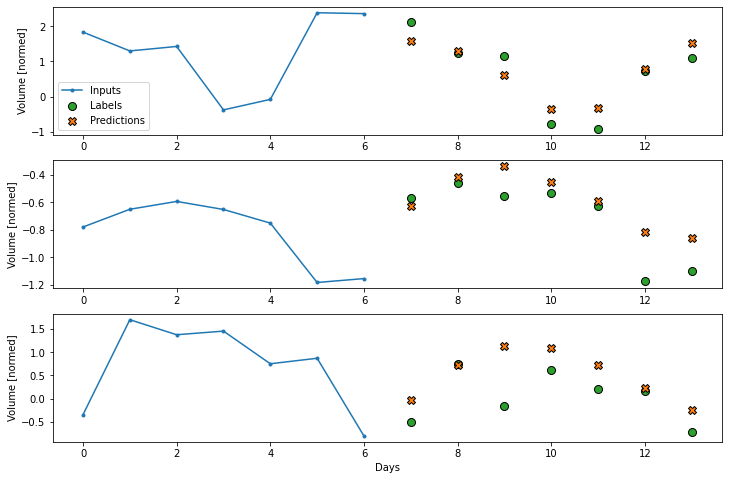

In [73]:
week_window.plot(rnn_model)

In [74]:
rnn_model.predict(week_window.test).shape

(135, 7, 12)

In [75]:
predictions_rnn = rnn_model.predict(week_window.test)[:, -1, 0]
predictions_rnn = predictions_rnn * train_std[0] + train_mean[0]
predictions_rnn = pd.Series(predictions_rnn)
predictions_rnn.index = y_test.index
predictions_rnn

2020-01-07    2081.551758
2020-01-08    1441.925781
2020-01-09    2817.322021
2020-01-10    1845.028687
2020-01-11    1513.108887
                 ...     
2020-05-16    2489.498535
2020-05-17    2331.272217
2020-05-18    1242.037964
2020-05-19    1705.009766
2020-05-20     976.652466
Freq: D, Length: 135, dtype: float32

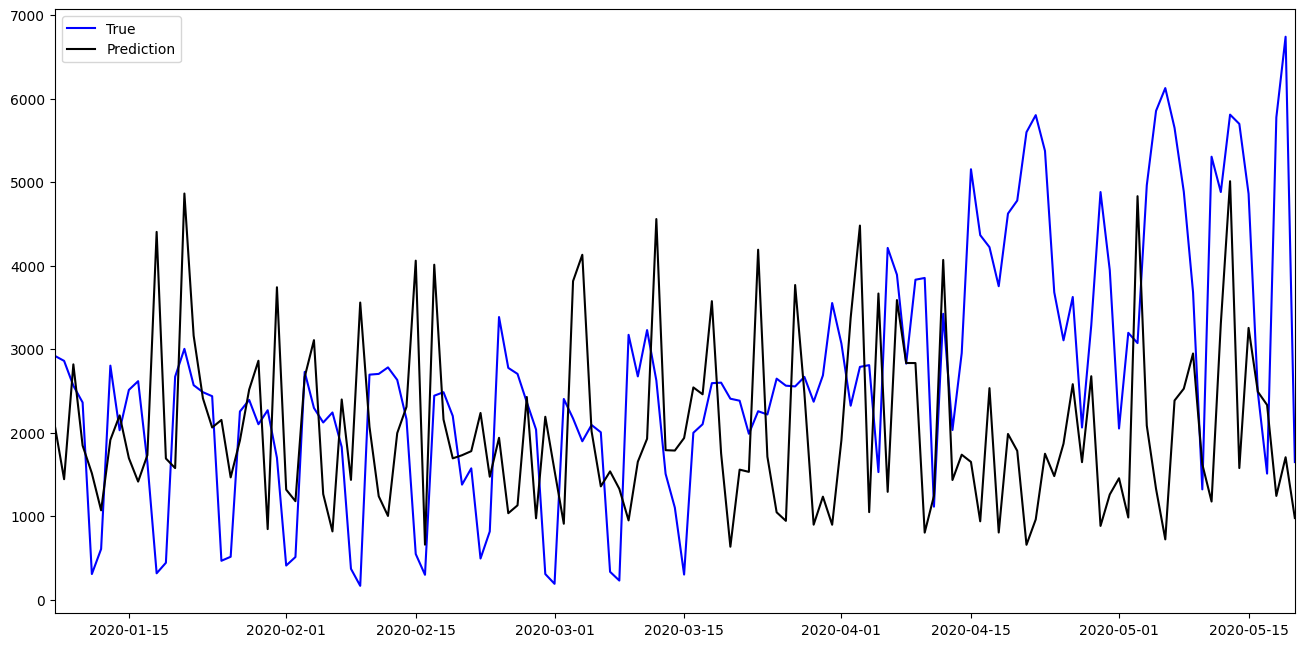

In [76]:
plot_prediction_vs_true(yhat=predictions_rnn, ytest=y_test)

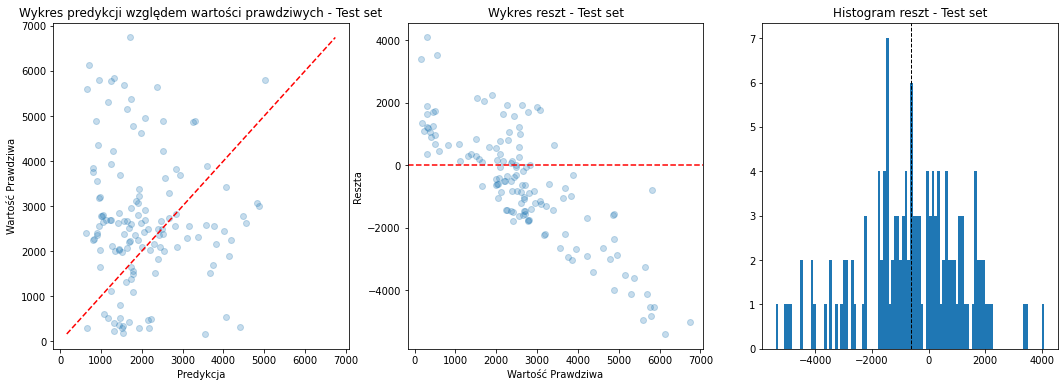

RMSE Test: 1928.9242052689867
Pomniejszony zysk: 1478361.0


In [77]:
model_evaluation(yhat=predictions_rnn, ytest=y_test)